In [3]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate, special
from scipy.integrate import ode, solve_ivp, odeint
from scipy.optimize import minimize

import emcee, corner
from multiprocessing import Pool

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 12

sys.path.append('../')
import bubbles

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Optically thin region

How big is proximity zone around galaxies? What is required ionizing flux to observe blue Lya?

In [5]:
R_p = 200.*u.km/u.s /Planck15.H(z=6.6)
R_p

<Quantity 0.2526515 Mpc>

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


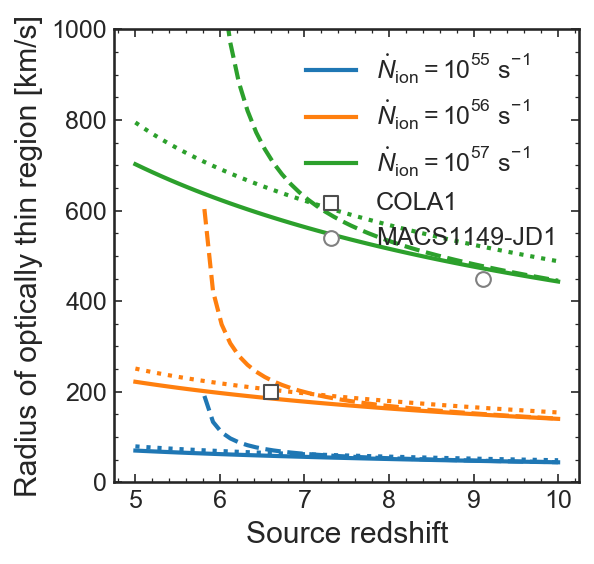

In [6]:
ztab = np.linspace(5., 10)
Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

observations = {}
observations['COLA1'] = {'z':6.6, 'vlim':200, 'M1500':-21.6, 'M1500_err':0.3, 'c':'0.3', 'ms':'s'}
observations['MACS1149-JD1'] = {'z':9.11, 'vlim':450, 'M1500':-18.5, 'M1500_err':0.1, 'c':'0.5', 'ms':'o'}

for ob in observations:
    plt.scatter(observations[ob]['z'], observations[ob]['vlim'], 
                lw=1, edgecolors=observations[ob]['c'], facecolor='w', 
                s=50, marker=observations[ob]['ms'], 
                zorder=100, label=ob)
#     plt.annotate(ob, xy=(observations[ob]['z']-0.1, observations[ob]['vlim']), 
#                  xycoords='data', ha='right', va='center')

for Ndot_ion in Ndot_ion_tab:
    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-1.8, fesc=1)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)    
    ln = plt.plot(ztab, vlim, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))

    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-1.8, fesc=1, J_bg=50)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)   
    plt.plot(ztab, vlim, c=ln[0].get_color(), ls='dashed')

    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-2.5, fesc=1, J_bg=1)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)   
    plt.plot(ztab, vlim, c=ln[0].get_color(), ls='dotted')

plt.legend()

plt.ylim(0., 1000)
plt.xlabel('Source redshift')
plt.ylabel('Radius of optically thin region [km/s]')

plt.savefig('../figs/Ralpha_z.pdf', bbox_inches='tight')

## As a function of Ndot_ion

To compare with Bolton & Haehnelt (2007) ~ 2-5 pMpc for Ndot_ion ~ 1-7e57 s^-1

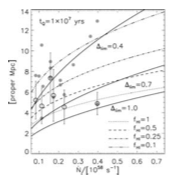

Text(0, 0.5, 'Radius of optically thin region [pMpc]')

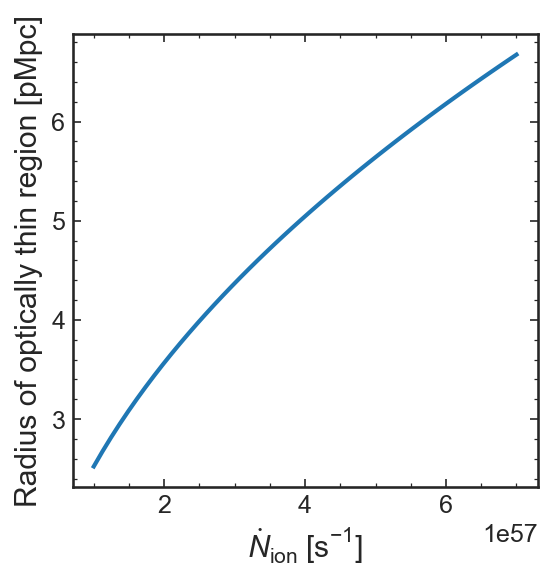

In [7]:
ztest = 6
Ndot_ion_tab = np.linspace(0.1,0.7)*1e58/u.s

R_alpha = bubbles.R_optically_thin(z=ztest, Ndot_ion=Ndot_ion_tab, 
                           reccase='A', alpha_s=-1.5, fesc=1, C=1, T=2e4*u.K)    
    
plt.plot(Ndot_ion_tab, R_alpha)

plt.xlabel('$\dot{N}_\mathrm{ion} \; [$s$^{-1}]$')
plt.ylabel('Radius of optically thin region [pMpc]')

## As a function of UV magnitude

In [212]:
10**(-48.6/2.5)

3.630780547701003e-20

In [213]:
beta = -2
z = 8
print(-((beta + 1) * 2.5))
bubbles.Muv_to_Nion(-21.6, z=6.6, alpha_s=-2, beta=-2)

2.5


<Quantity 1.08758893e+56 1 / s>

In [278]:
f0 = 3.631E-20*u.erg/u.s/u.Hz/u.cm**2.
(4*np.pi*f0 * (10*u.pc)**2./const.h).to(1./u.s)

<Quantity 6.55663762e+46 1 / s>

Text(0.5, 0, 'UV magnitude, $M_{1500}$')

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


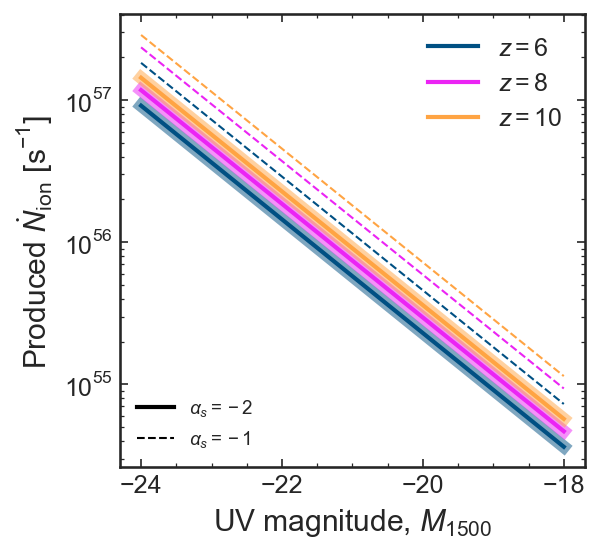

In [234]:
from palettable.cubehelix import cubehelix3_16
col = cubehelix3_16.hex_colors

def Nion_from_Muv(Muv, z, beta, alpha_s):
    f0 = 3.631E-20*u.erg/u.s/u.Hz/u.cm**2.
    Lnu_912 = 4*np.pi*f0 * (10*u.pc)**2. * (1+z)**-(beta+1) * (912./1500)**(beta+2) * 10**(-0.4*Muv)
    Nion = Lnu_912/const.h/-alpha_s
    return Nion.to(1/u.s)

Muv_tab = np.linspace(-24, -18)
z_test = [6., 8., 10.]
alpha_s_test = [-2., -1.]
lw = [2, 1]
ls = ['solid', 'dashed', 'dotted']

for zz, z in enumerate(z_test):
    ln = plt.plot(Muv_tab, bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s_test[0]), 
                      lw=lw[0], c=col[3+zz*4], ls=ls[0], label='$z=%.0f$' % z)
    plt.semilogy(Muv_tab, bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s_test[1]), 
                 lw=lw[1], c=ln[0].get_color(), ls=ls[1])
    
    plt.semilogy(Muv_tab, Nion_from_Muv(Muv_tab, z=z, beta=-2, alpha_s=alpha_s_test[0]), 
                 lw=6, c=ln[0].get_color(), alpha=0.5)
    
handles = []
for i, alpha_s in enumerate(alpha_s_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label=r'$\alpha_s = %.0f$' % alpha_s)
    handles.append(ln)
    
leg = plt.legend(handles=handles, loc='lower left', fontsize=9)
plt.gca().add_artist(leg)

plt.legend()
plt.ylabel('Produced $\dot{N}_\mathrm{ion}$ [s$^{-1}$]')
plt.xlabel('UV magnitude, $M_{1500}$')

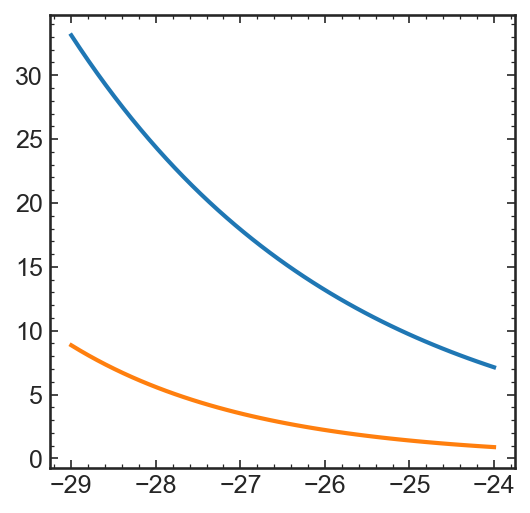

In [235]:
Muv_tab = np.linspace(-24, -18)
Muv_tab = np.linspace(-29, -24)

z_s = 6.

Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z_s, alpha_s=-2, beta=-2)

R_CenHaiman = bubbles.R_bubble_CenHaiman2000(z_s, Ndot_ion=Ndot_ion_tab, t_source=1e8*u.yr)
R_alpha = bubbles.R_optically_thin(z=z_s, Ndot_ion=Ndot_ion_tab, 
                                   reccase='B', alpha_s=-2, 
                                   fesc=1, C=3, T=1e4*u.K, J_bg=1)  
plt.plot(Muv_tab, R_CenHaiman)
plt.plot(Muv_tab, R_alpha)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


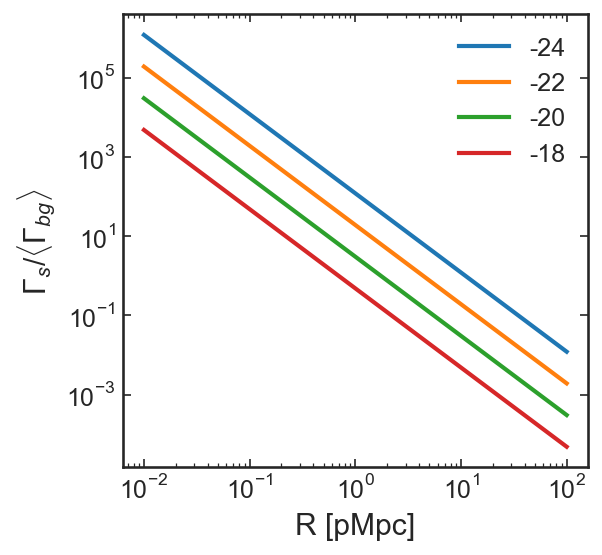

In [295]:
# Compare gamma_BG to source flux
def Gamma12(r, z_s, Ndot_ion, fesc=1., C=3., T=1e4, 
            J_bg=1., alpha=-2):
    """
    R is proper distance

    Neutral fraction from source
    (Mesinger+04)
    
    for fesc = 0.5, Nion = 1e-57/s

    Args:
        J_bg (float): scaling of average UV background
    """    
    # J_source_integrand = bubbles.L_nu(nu_tab, qso=qso, alpha=alpha) * sigma_ion/(bubbles.h_erg_s * nu_tab)
    
    J_source           = fesc * Ndot_ion * (alpha/(alpha - 3)) * bubbles.sigma_ion0

    Gamma12_source     = fesc/(4. * np.pi * r**2.) * J_source
    Gamma12_background = J_bg * bubbles.Gamma12(z_s) / u.s
    
    return Gamma12_source.to(1./u.s), Gamma12_background

Muv_tab = np.arange(-24, -16, 2)

Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=7, alpha_s=-2, beta=-2)

Rtab = np.logspace(-2, 2) * u.Mpc
for i, Ndot_ion in enumerate(Ndot_ion_tab):
    gamma_s, gamma_bg = Gamma12(r=Rtab, z_s=7., Ndot_ion=Ndot_ion, fesc=1., C=3., T=1e4, J_bg=1.)
    
    plt.loglog(Rtab, gamma_s/gamma_bg, label=Muv_tab[i])
    
plt.xlabel('R [pMpc]')
plt.ylabel(r'$\Gamma_s/\langle\Gamma_{bg}\rangle$')
plt.legend()

0.0
0.6666666666666667


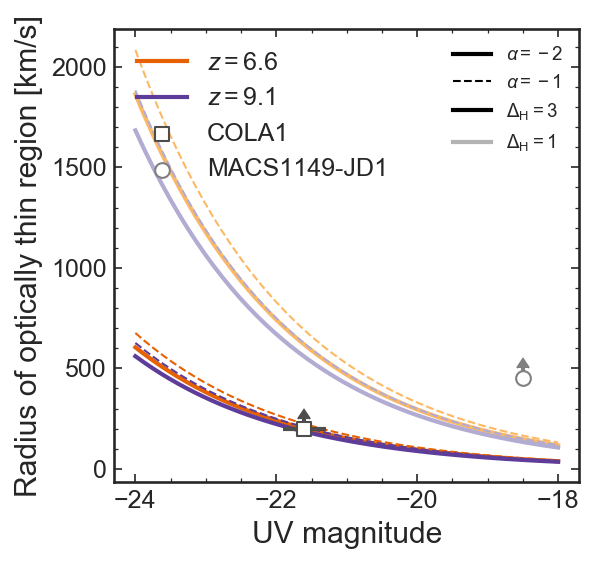

In [236]:
from palettable.colorbrewer.diverging import PuOr_4
col = PuOr_4.hex_colors # o_d, o_l, p_l, p_d


ztest = [6.6, 9.11]#7., 8.]
alpha_s_test = [-2, -1]
C_test = [3, 1]
Muv_tab = np.linspace(-24, -18)

ls = ['solid', 'dashed', 'dotted']
lw = [2, 1, 1]

for ob in observations:
    plt.scatter(observations[ob]['M1500'], observations[ob]['vlim'],
                lw=1, edgecolors=observations[ob]['c'], facecolor='w', 
                s=50, marker=observations[ob]['ms'], 
                zorder=100, label=ob)
    plt.errorbar(observations[ob]['M1500'], observations[ob]['vlim'], 
                    xerr=observations[ob]['M1500_err'], yerr=50, zorder=80,
                    lw=2, color=observations[ob]['c'], lolims=True)  
    
for zz, z in enumerate(ztest):

    for i, alpha_s in enumerate(alpha_s_test):

        Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s, beta=-2)

        for cc, C in enumerate(C_test):
            R_alpha = bubbles.R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                                   reccase='B', alpha_s=alpha_s, 
                                   fesc=1, C=C, T=1e4*u.K, J_bg=1)        
            vlim = bubbles.blue_velocity_lim(R_alpha, z)   

            # Only make label for C=3 and alpha = -2
            if i == 0 and cc == 0:
                label = '$z=%.1f$' % z
            else:
                label = None
            
            if zz == 0:
                c = col[zz+cc]
                # z=6.6 orange, dark for C = 1 (0)
#                 print(zz+cc)
            else:
                c = col[zz+1+np.abs(cc - 1)]
                # z=9.1 purple, dark for C = 1 (3)
#                 print(zz+1+np.abs(cc - 1))
            plt.plot(Muv_tab, vlim, c=c, ls=ls[i], lw=lw[i], label=label)
        
handles = []
for i, alpha_s in enumerate(alpha_s_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label=r'$\alpha = %.0f$' % alpha_s)
    handles.append(ln)
for i, C in enumerate(C_test):
    print(1-C/3.)
    ln = mlines.Line2D([], [], color='%.1f' % (1-C/3.), label=r'$\Delta_\mathrm{H} = %.0f$' % C)
    handles.append(ln)
    
leg = plt.legend(handles=handles, loc='upper right', fontsize=9)
plt.gca().add_artist(leg)

plt.legend(loc='upper left')

plt.xlabel('UV magnitude')
plt.ylabel('Radius of optically thin region [km/s]')

plt.savefig('../figs/Ralpha_Muv.pdf', bbox_inches='tight')

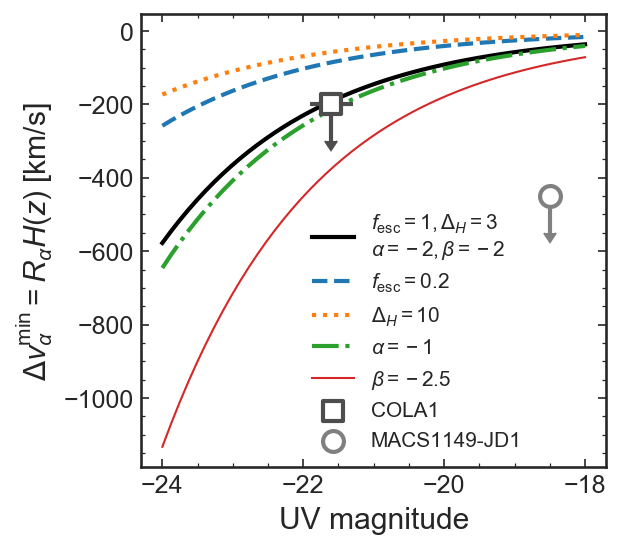

In [410]:
from palettable.colorbrewer.diverging import PuOr_4
col = PuOr_4.hex_colors # o_d, o_l, p_l, p_d

plt.figure()

alpha_s_test = [-2, -1]
C_test = [1, 3]
fesc_test = [1, 0.2]
Muv_tab = np.linspace(-24, -18)

alpha_fid = -2.
fesc_fid = 1.
C_fid = 3.
beta_fid = -2.

ls = ['solid', 'dashed', 'dotted']
lw = [2, 1, 1]

for ob in observations:
    plt.scatter(observations[ob]['M1500'], -observations[ob]['vlim'],
            lw=2, edgecolors=observations[ob]['c'], facecolor='w', 
            s=100, marker=observations[ob]['ms'], 
            zorder=100, label=ob)
    plt.errorbar(observations[ob]['M1500'], -observations[ob]['vlim'], 
                xerr=observations[ob]['M1500_err'], yerr=100, zorder=80,
                lw=2, color=observations[ob]['c'], uplims=True)  


z = 8.

def get_vlim(z, alpha_s, fesc, C, beta=-2):
    
    Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s, beta=beta)

    R_alpha = bubbles.R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                               reccase='B', alpha_s=alpha_s, 
                               fesc=fesc, C=C, T=1e4*u.K, J_bg=1)        

    vlim = bubbles.blue_velocity_lim(R_alpha, z)  
    
    return vlim

vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=C_fid, beta=beta_fid)
plt.plot(Muv_tab, -vlim, c='k', label=r'$f_\mathrm{esc}=1, \Delta_H=3$'+'\n'+r'$\alpha=-2, \beta=-2$')

vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=0.2, C=C_fid)
plt.plot(Muv_tab, -vlim, ls='dashed', label=r'$f_\mathrm{esc} = 0.2$')

vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=10)
plt.plot(Muv_tab, -vlim, ls='dotted', label=r'$\Delta_H = 10$')

vlim = get_vlim(z=z, alpha_s=-1, fesc=fesc_fid, C=C_fid)
plt.plot(Muv_tab, -vlim, ls='dashdot', label=r'$\alpha = -1$')

vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=C_fid, beta=-2.5)
plt.plot(Muv_tab, -vlim, lw=1, label=r'$\beta=-2.5$')

plt.xlabel('UV magnitude')
plt.ylabel(r'$\Delta v_\alpha^\mathrm{min} = R_\alpha H(z)$ [km/s]')

plt.legend(loc=(0.35, 0.02), fontsize=10)
plt.savefig('../figs/Ralpha_Muv_all_1panel.pdf', bbox_inches='tight')

# Infer properties from proximity zone size

Infer:
- alpha_s
- beta
- C
- fesc

In [305]:
bubbles.Gamma12(6.6)

10**0.4

2.51188643150958

In [356]:
def lnlike(theta, vlim, sigma_v, Muv, Muv_err, z, fix_bg):
    """
    Likelihood for observing vlim+sigma_v given theta
    
    Likelihood is that R_alpha > vlim/H(z) --> erfc
    
    """
    
    if fix_bg is True:
        fesc, C, alpha_s, beta = theta
        J_bg = 0.
    
    else:
        fesc, C, alpha_s, beta, gamma_bg_12 = theta    
#         J_bg = 10**log_gamma_bg_12 * 1e-12 / bubbles.Gamma12(z)
        J_bg = gamma_bg_12 * 1e-12 / bubbles.Gamma12(z)
    
    
    R_obs     = np.abs(vlim / Planck15.H(z)).to(u.Mpc)
    R_obs_err = np.abs(sigma_v / Planck15.H(z)).to(u.Mpc)

    # Ionizing photon flux
    Muv_draw = np.random.normal(loc=Muv, scale=Muv_err)
    Ndot_ion = bubbles.Muv_to_Nion(Muv_draw, z, alpha_s=alpha_s, beta=beta)
    
    # Model proximity zone
    R_mod = bubbles.R_optically_thin(z, Ndot_ion=Ndot_ion, alpha_s=alpha_s, 
                                     fesc=fesc, C=C,
                                     reccase='B', T=1e4*u.K, tau_lim=2.3, 
                                     J_bg=J_bg)
    
    if np.isnan(R_mod.value):
        R_mod = np.inf * u.Mpc
    
    likelihood = 0.5 * scipy.special.erfc((R_obs - R_mod) / np.sqrt(2.) / R_obs_err)

    return np.log(likelihood)

def lnprior(theta, fix_bg):
    
    if fix_bg:
        fesc, C, alpha_s, beta = theta
        
        if 0. <= fesc <= 1. and 0.2 < C < 10. \
        and -2.5 <= alpha_s <= -1. \
        and -3 < beta < -1:
            return 0.
        else:
            return -np.inf
        
    else:
        fesc, C, alpha_s, beta, gamma_bg_12 = theta
    
        if 0. <= fesc <= 1. and 0.2 < C < 10. \
        and -2.5 <= alpha_s <= -1. \
        and 0 <= gamma_bg_12 <= 10 \
        and -3 < beta < -1:
            return 0.
        else:
            return -np.inf
    
def lnposterior(theta, vlim, sigma_v, Muv, Muv_err, z, fix_bg):
    
    if lnprior(theta, fix_bg) == 0:
        return lnlike(theta, vlim, sigma_v, Muv, Muv_err, z, fix_bg)
    else:
        return -np.inf    

## Setup up inference

COLA1:

- Max blue peak = 250 km/s
- R~5000 ==> 60 km/s resolution

In [243]:
# Resolution R = l/dl = c/dv
R = 5000.
c = 3e5 * u.km/u.s

v_res = c/R
v_res

<Quantity 60. km / s>

## Fix background = 0

In [12]:
np.random.seed(42)
nll = lambda *args: -lnlike(*args)

initial = np.array([1., 1., -2., 0.1])
initial = np.array([1., 1., -2.,])

vlim, sigma_v, Muv, Muv_err, z, fix_bg = 250.*u.km/u.s, 60.*u.km/u.s, -21.6, 0.3, 6.6, True
soln = minimize(nll, initial, args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg))
soln.x

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


array([ 1.00000519,  0.99999869, -2.00000936])

In [77]:
labels = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$', r'$\beta_\mathrm{UV}$', r'$\Gamma_\mathrm{bg} [\mathrm{s}^{-1}]$']
labels = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$', r'$\Gamma_\mathrm{bg} [\mathrm{s}^{-1}]$']
labels = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$']

pos = initial + 1e-1 * np.random.randn(100, len(soln.x))
nwalkers, ndim = pos.shape

print('%i walkers, %i dimensions' % (nwalkers, ndim))

100 walkers, 4 dimensions


### Run inference

In [14]:
Nsteps = 8000
fix_bg = True

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, 
                                    args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg),
                                    pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, Nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

# Autocorrelation time
tau = sampler.get_autocorr_time()

  0%|          | 0/8000 [00:00<?, ?it/s]/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 8000/8000 [03:16<00:00, 40.68it/s]


Multiprocessing took 196.8 seconds


### Plot

In [16]:
sampler.get_autocorr_time()

array([65.35981906, 64.08332785, 65.86189221])

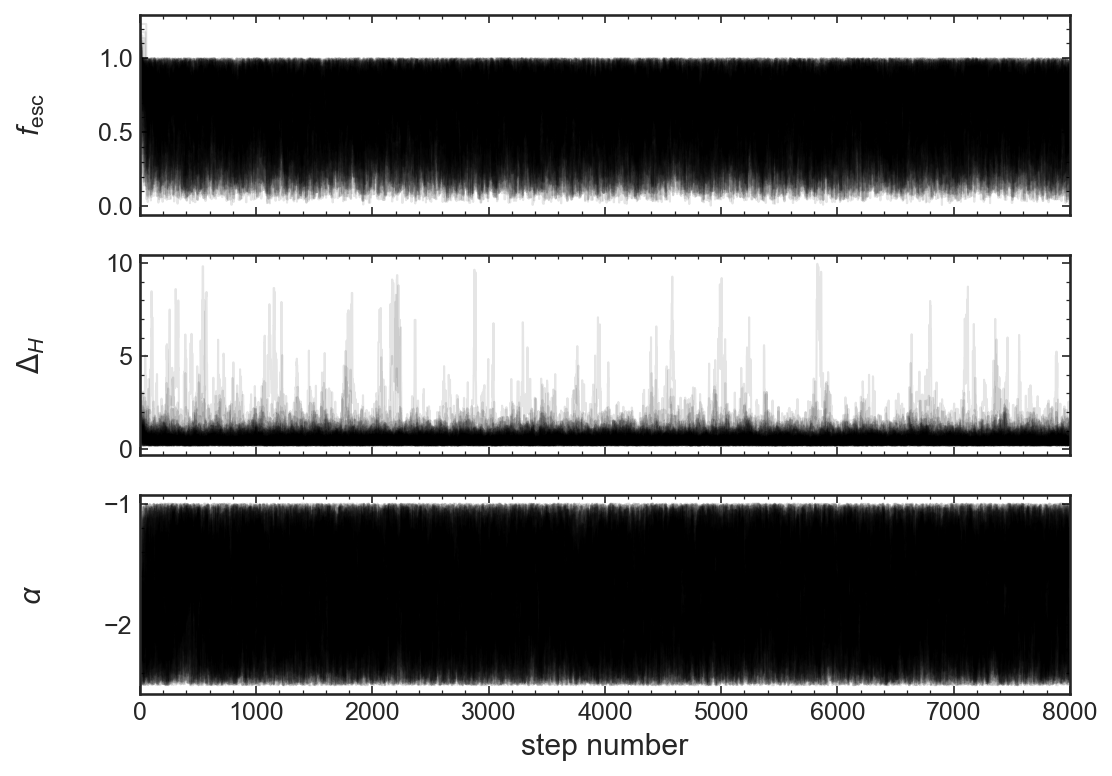

In [17]:
fig, axes = plt.subplots(ndim, figsize=(8, ndim*2), sharex=True)

samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1, lw=1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Autocorrelation time suggests that only about 150 steps are needed for the chain to “forget” where it started. 

It’s not unreasonable to throw away a few times this number of steps as “burn-in”. 

Let’s discard the initial 300 steps, thin by about half the autocorrelation time (75 steps), and flatten the chain so that we have a flat list of samples:

In [18]:
flat_samples = sampler.get_chain(discard=300, thin=50, flat=True)
print(flat_samples.shape)

(15400, 3)


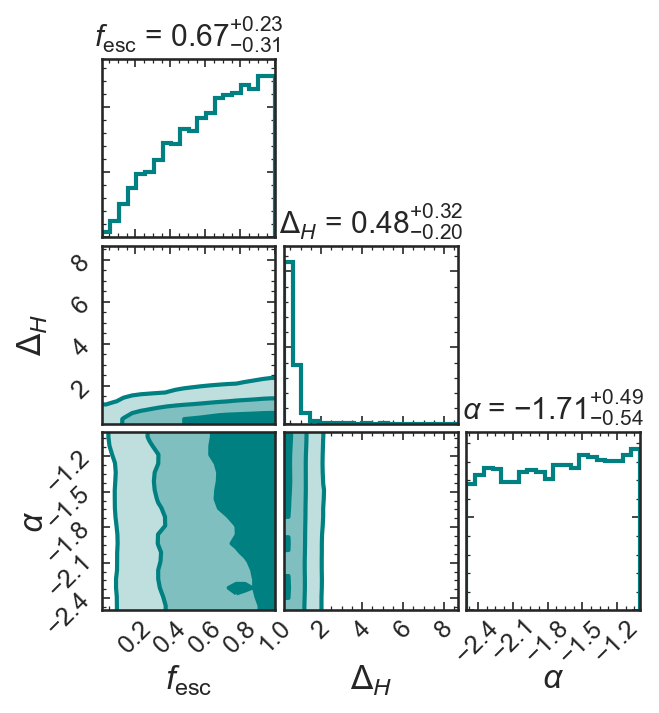

In [19]:
fig, ax = plt.subplots(ndim, ndim, figsize=(ndim+1.4, ndim+1.5), dpi=150)
corner.corner(flat_samples, fig=fig,
                labels=labels, smooth=1, 
                color='Teal', use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                fill_contours=True, hist_kwargs={'lw':2},
#                 quantiles=[0.16, 0.5, 0.84], 
                levels = 1.0 - np.exp(-0.5 * np.array([1,2,3]) ** 2),
#               levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2),
                show_titles=True, 
                label_kwargs={"fontsize": 16})
plt.savefig('../figs/COLA1_Ralpha_corner.pdf', bbox_inches='tight')
plt.show()

## Let background free

In [175]:
np.random.seed(42)
nll = lambda *args: -lnlike(*args)

initial = np.array([1., 1., -2., 0.1])

vlim, sigma_v, Muv, Muv_err, z, fix_bg = 250.*u.km/u.s, 60.*u.km/u.s, -21.6, 0.3, 6.6, False
soln = minimize(nll, initial, args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg))
soln.x

array([ 1.00000012,  0.99999997, -2.00000022,  0.10000014])

In [78]:
labels_bg = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$', r'$\Gamma_\mathrm{bg} [10^{-12} \mathrm{s}^{-1}]$']

pos_bg = initial + 1e-1 * np.random.randn(100, len(soln.x))
nwalkers_bg, ndim_bg = pos_bg.shape

print('%i walkers, %i dimensions' % (nwalkers_bg, ndim_bg))

100 walkers, 4 dimensions


In [22]:
Nsteps = 8000
fix_bg = False

with Pool() as pool:
    sampler_bg = emcee.EnsembleSampler(nwalkers_bg, ndim_bg, lnposterior, 
                                    args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg),
                                    pool=pool)
    start = time.time()
    sampler_bg.run_mcmc(pos_bg, Nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

# Autocorrelation time
tau = sampler.get_autocorr_time()

  0%|          | 0/8000 [00:00<?, ?it/s]/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 3/8000 [00:00<04:54, 27.13it/s]/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  0%|          | 8/8000 [00:00<04:20, 30.67it/s]/home

Multiprocessing took 196.2 seconds


### Plot

In [24]:
sampler_bg.get_autocorr_time()

array([ 99.10427471,  95.39028477,  94.47646085, 101.78255877])

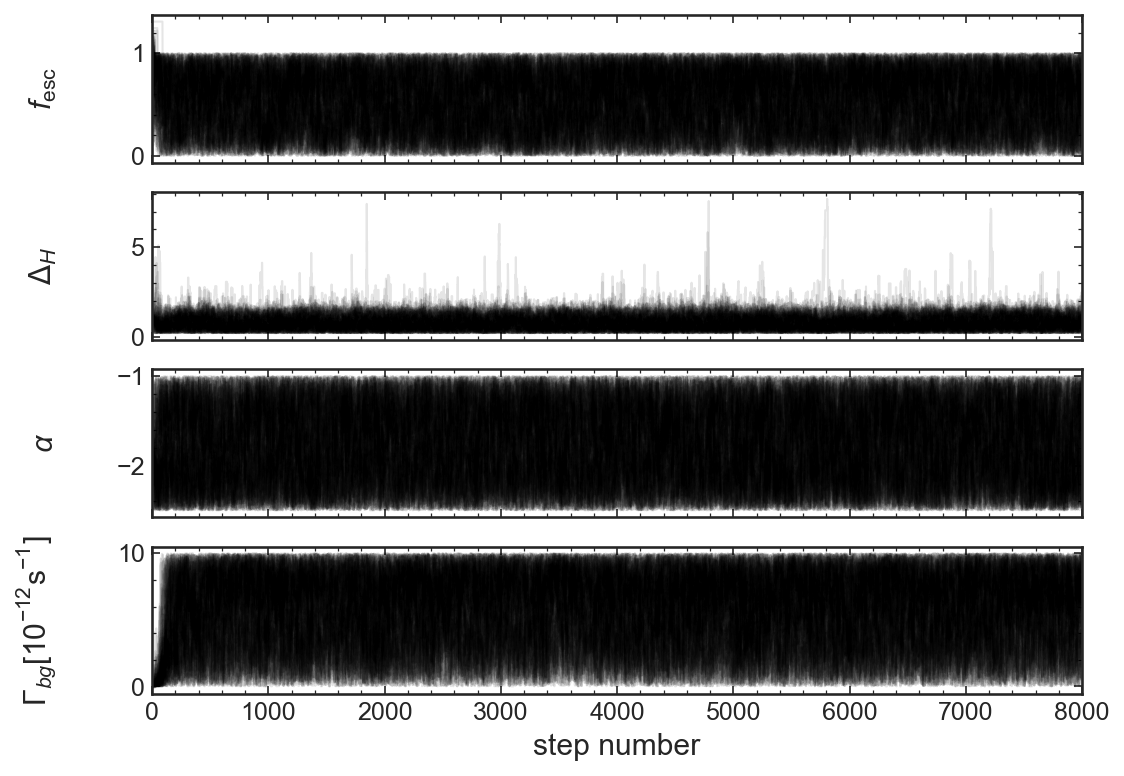

In [25]:
fig, axes = plt.subplots(ndim_bg, figsize=(8, ndim*2), sharex=True)

samples_bg = sampler_bg.get_chain()

for i in range(ndim_bg):
    ax = axes[i]
    ax.plot(samples_bg[:, :, i], "k", alpha=0.1, lw=1)
    ax.set_xlim(0, len(samples_bg))
    ax.set_ylabel(labels_bg[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(15400, 4)


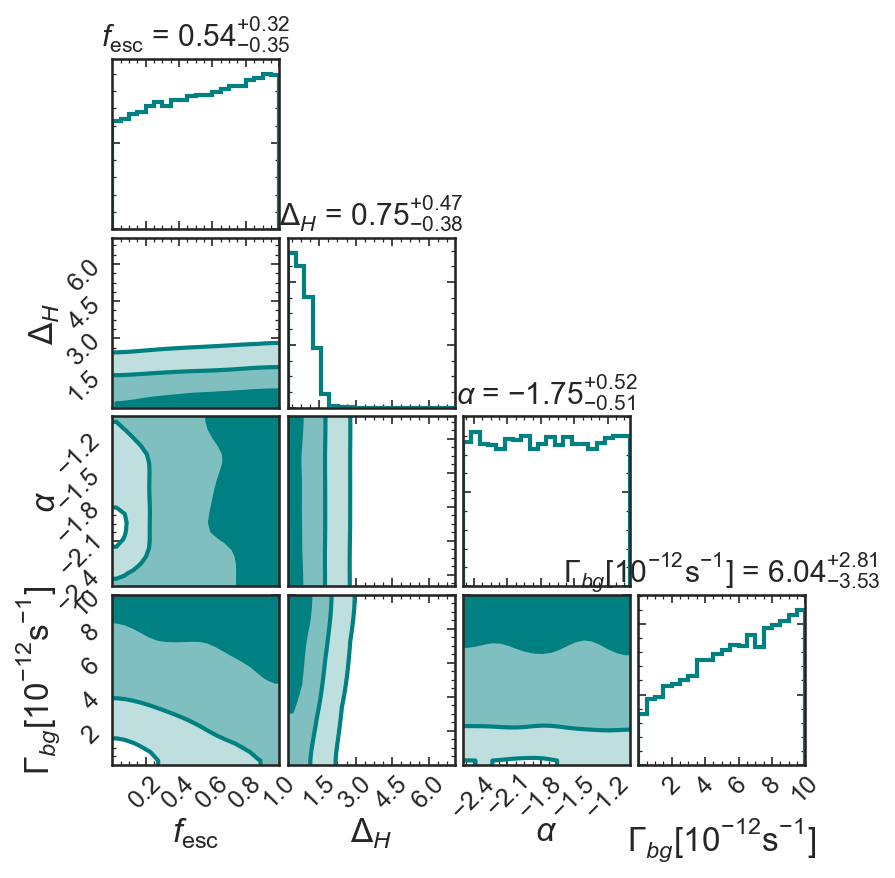

In [26]:
flat_samples_bg = sampler_bg.get_chain(discard=300, thin=50, flat=True)
print(flat_samples_bg.shape)

fig, ax = plt.subplots(ndim_bg, ndim_bg, figsize=(ndim_bg+1.4, ndim_bg+1.5), dpi=150)
corner.corner(flat_samples_bg, fig=fig,
                labels=labels_bg, smooth=2, 
                color='Teal', use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                fill_contours=True, hist_kwargs={'lw':2},
#                 quantiles=[0.16, 0.5, 0.84], 
                levels = 1.0 - np.exp(-0.5 * np.array([1,2,3]) ** 2),
#               levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2),
                show_titles=True, 
                label_kwargs={"fontsize": 16})

plt.savefig('../figs/COLA1_Ralpha_corner_free_J_bg.pdf', bbox_inches='tight')

## Plot both

NameError: name 'logZ_nobg' is not defined

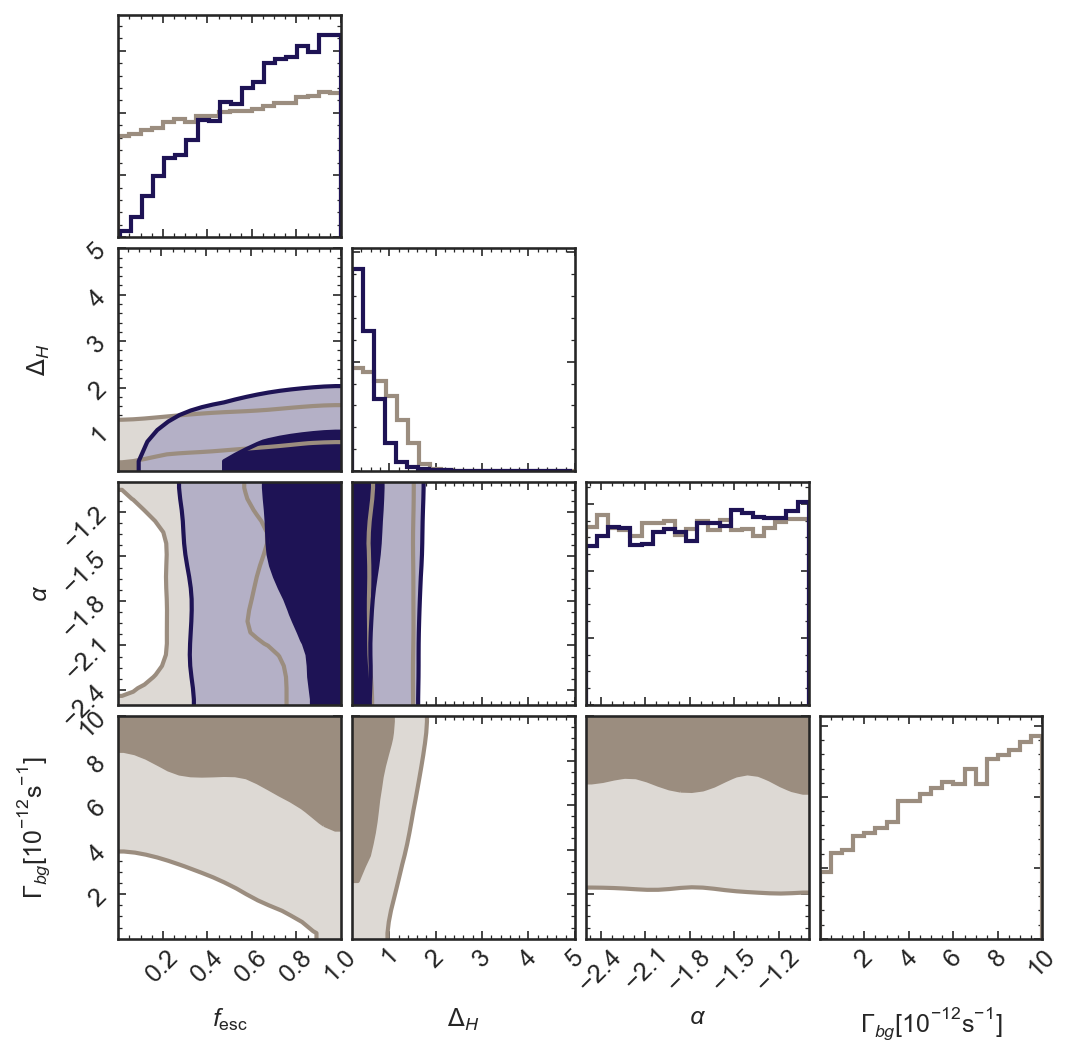

In [32]:
def get_med_errs(array, quantiles=[16., 50., 84.]):
    return [np.percentile(array, q) for q in quantiles]
    
col_bg   = 'grey'
col_nobg = 'tab:blue'

col_bg   = '#9B8D7F'
col_nobg = '#1E1355'

# fig, ax = plt.subplots(ndim_bg, ndim_bg, figsize=(ndim_bg+1.4, ndim_bg+1.5), dpi=100)
fig, ax = plt.subplots(ndim_bg, ndim_bg, figsize=(1.8*ndim_bg, 1.8*ndim_bg), dpi=150)

expand_flat_samples = np.append(flat_samples, -5 + np.random.normal(0., 1, (len(flat_samples),1)), 1)

# With background
corner.corner(flat_samples_bg, fig=fig,
              range=[(0.,1), (0.2,5), (-2.5,-1), (0,10)],
                labels=labels_bg, smooth=2, 
                color=col_bg, use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                fill_contours=True, hist_kwargs={'lw':2, 'density':True},
                levels = 1.0 - np.exp(-0.5 * np.array([1,2]) ** 2),
#                 show_titles=True,        
                label_kwargs={"fontsize": 12})


for i,j in it.product(range(3), range(3)):
    
    # 2D hist
    if i > j:
        corner.hist2d(expand_flat_samples[:,j], expand_flat_samples[:,i], 
                      ax=ax[i,j], bins=20, 
                      levels=1.0 - np.exp(-0.5 * np.array([1,2]) ** 2), 
                      smooth=2, color=col_nobg, 
                      plot_datapoints=False, plot_density=False, plot_contours=True, 
                      no_fill_contours=False, fill_contours=True)
        
    # diagonal
    if i == j:        
        if i == 1:
            data = expand_flat_samples[:,i][expand_flat_samples[:,i] <= 5.]
        else:
            data = expand_flat_samples[:,i]
            
        n, bins, patches = ax[i,j].hist(data, bins=20, histtype='step', color=col_nobg, density=True, lw=2)
        ax[i,j].set_ylim(0., 1.1*np.max(n))
        
# Set delta_H lims        
[axi.set_xlim(0.2,5) for axi in ax[:,1]]
ax[1,0].set_ylim(0.2,5)

# Legend
ax[0,1].annotate('No background ($\ln{Z} = %.2f$)' % logZ_nobg[-1], xy=(0.,0.9), xycoords='axes fraction', color=col_nobg)
for i, label in enumerate(labels):    
    low, med, high = get_med_errs(flat_samples[:,i])
    low_err, high_err = med-low, high-med    
#     ax[0,1].annotate('%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err), xy=(0.,0.7-i/5.), xycoords='axes fraction', color=col_nobg)
    ax[i,i].annotate('%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err), 
                     xy=(0.95,0.3), xycoords='axes fraction', fontsize=9, ha='right', color=col_nobg)
    
# ax[0,2].annotate('With ionizing background', xy=(0.,0.9), xycoords='axes fraction')
ax[0,1].annotate('With ionizing background ($\ln{Z} = %.2f$)' % logZ_withbg[-1], xy=(0.,0.75), xycoords='axes fraction', color='0.4')
for i, label in enumerate(labels_bg):
    low, med, high = get_med_errs(flat_samples_bg[:,i])
    low_err, high_err = med-low, high-med    
#     ax[0,2].annotate('%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err), xy=(0.,0.7-i/5.), xycoords='axes fraction')
    ax[i,i].annotate('%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err), 
                     xy=(0.95,0.1), xycoords='axes fraction', fontsize=9, ha='right', color='0.4')    

plt.savefig('../figs/COLA1_Ralpha_corner_both.pdf', bbox_inches='tight')

# Run with dynesty

In [341]:
# Dynesty imports
from multiprocessing import Pool
import dynesty
from dynesty import plotting as dyplot
from dynesty import DynamicNestedSampler
from dynesty import utils as dyfunc
import ipyparallel as ipp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import pickle

np.seterr(divide='ignore')

%timeit
%lprun

# To use multiprocessing run following command:
# > ipcluster start -n 7
rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)
dview = rc[:]
dview.use_dill();

[0, 1, 2, 3, 4, 5, 6]


In [355]:
def prior_transform(utheta, args):
    """
    utheta = U(0,1)
    """
    fix_bg_bool = args
    
    if fix_bg_bool is True:
        ufesc, uC, ualpha_s, ubeta = utheta
        fesc    = ufesc                # 0 - 1
        C       = 10.2*uC + 0.2        # 0.2 - 10
        alpha_s = -(1.5*ualpha_s + 1.) # 
        beta    = 2*ubeta - 3.      # -3 - -1
        return fesc, C, alpha_s, beta      
    else:
        ufesc, uC, ualpha_s, ubeta, ugamma_bg_12 = utheta
#         ufesc, uC, ualpha_s, ulog_gamma_bg_12 = utheta
        fesc    = ufesc                # 0 - 1
        C       = 10.2*uC + 0.2        # 0.2 - 10
        alpha_s = -(1.5*ualpha_s + 1.) #
        beta    = 2*ubeta - 3.         # -3 - -1
        gamma_bg_12 = 20.*ugamma_bg_12 # 0 - 10
#         log_gamma_bg_12 = -2.4*ulog_gamma_bg_12 + 0.4

        return fesc, C, alpha_s, beta, gamma_bg_12

In [373]:
vlim, sigma_v, Muv, Muv_err, z, = 250.*u.km/u.s, 60.*u.km/u.s, -21.6, 0.3, 6.6
fix_bg = True
ndim   = 4

chain_file_nobg = "../chains/res_nobg.pickle"
chain_file_nobg = "../chains/res_nobg_fixNionMuv.pickle"
chain_file_nobg = "../chains/res_nobg_fixNionMuv_beta.pickle"

maxiter = 50000
if __name__ == '__main__':
   
    # sample from the target distribution
    t0 = time.time()
    npool = 7
    with ProcessPoolExecutor(max_workers=npool) as executor:
        
        sampler = DynamicNestedSampler(
                                lnlike, prior_transform, ndim, 
                                logl_args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg),
                                ptform_args=[fix_bg],
                                pool=executor, queue_size=npool,
                                bound='multi', sample='rwalk')
        
        sampler.run_nested(dlogz_init=0.001, nlive_init=500, maxiter=maxiter, use_stop=False)#wt_kwargs={'pfrac': 1.0})
        
        res_fixbg = sampler.results        
        pickle.dump(res_fixbg, open(chain_file_nobg,"wb"))

    t_run = (time.time()-t0)/60.
    print("Took {0:.10f} mins".format(t_run))

iter: 50000 | batch: 42 | bound: 0 | nc: 1 | ncall: 284205 | eff(%): 17.593 | loglstar:   -inf <  0.000 < -0.001 | logz: -1.594 +/-  0.018 | stop:    nan                     


Took 7.3793163935 mins


In [374]:
vlim, sigma_v, Muv, Muv_err, z = 250.*u.km/u.s, 60.*u.km/u.s, -21.6, 0.3, 6.6
fix_bg = False
ndim_bg   = 5

chain_file_wbg = "../chains/res_withbg.pickle"
chain_file_wbg = "../chains/res_withbg_100.pickle"
chain_file_wbg = "../chains/res_withbg_fixNionMuv_beta.pickle"

maxiter = 50000
if __name__ == '__main__':
   
    # sample from the target distribution
    t0 = time.time()
    npool = 7
    with ProcessPoolExecutor(max_workers=npool) as executor:
        
        sampler = DynamicNestedSampler(
                                lnlike, prior_transform, ndim_bg, 
                                logl_args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg),
                                ptform_args=[[fix_bg]],
                                pool=executor, queue_size=npool,
                                bound='multi', sample='rwalk')
        
        sampler.run_nested(dlogz_init=0.001, nlive_init=500, maxiter=maxiter, use_stop=False, wt_kwargs={'pfrac': 1.0})
        
        res_withbg = sampler.results 
        pickle.dump(res_withbg, open(chain_file_wbg,"wb"))

    t_run = (time.time()-t0)/60.
    print("Took {0:.10f} mins".format(t_run))

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: i

Took 8.7368950208 mins


### Dynesty plots

In [352]:
def dyn_plots(results, corner=True, labels=None):
    # Plot a summary of the run.
    rfig, raxes = dyplot.runplot(results, span=[0.0, (0., 1.1), 0.0, (0., 1.05*np.exp(np.nanmax(results.logz)))])

    # Plot traces and 1-D marginalized posteriors.
    tfig, taxes = dyplot.traceplot(results, labels=labels)

    # Plot the 2-D marginalized posteriors.
    if corner:
        cfig, caxes = dyplot.cornerplot(results, labels=labels, show_titles=True)
    return

def load_samples(chain_file, save=False):
    res = pickle.load(open(chain_file, 'rb'))
    
    samples = res.samples  # samples
    weights = np.exp(res.logwt - res.logz[-1])  # normalized weights
    samples = dyfunc.resample_equal(samples, weights) # Resample weighted samples.
    
    if save:
        np.save(chain_file.replace('.pickle','_samples'), samples)
        
    return samples, res.logz[-1]

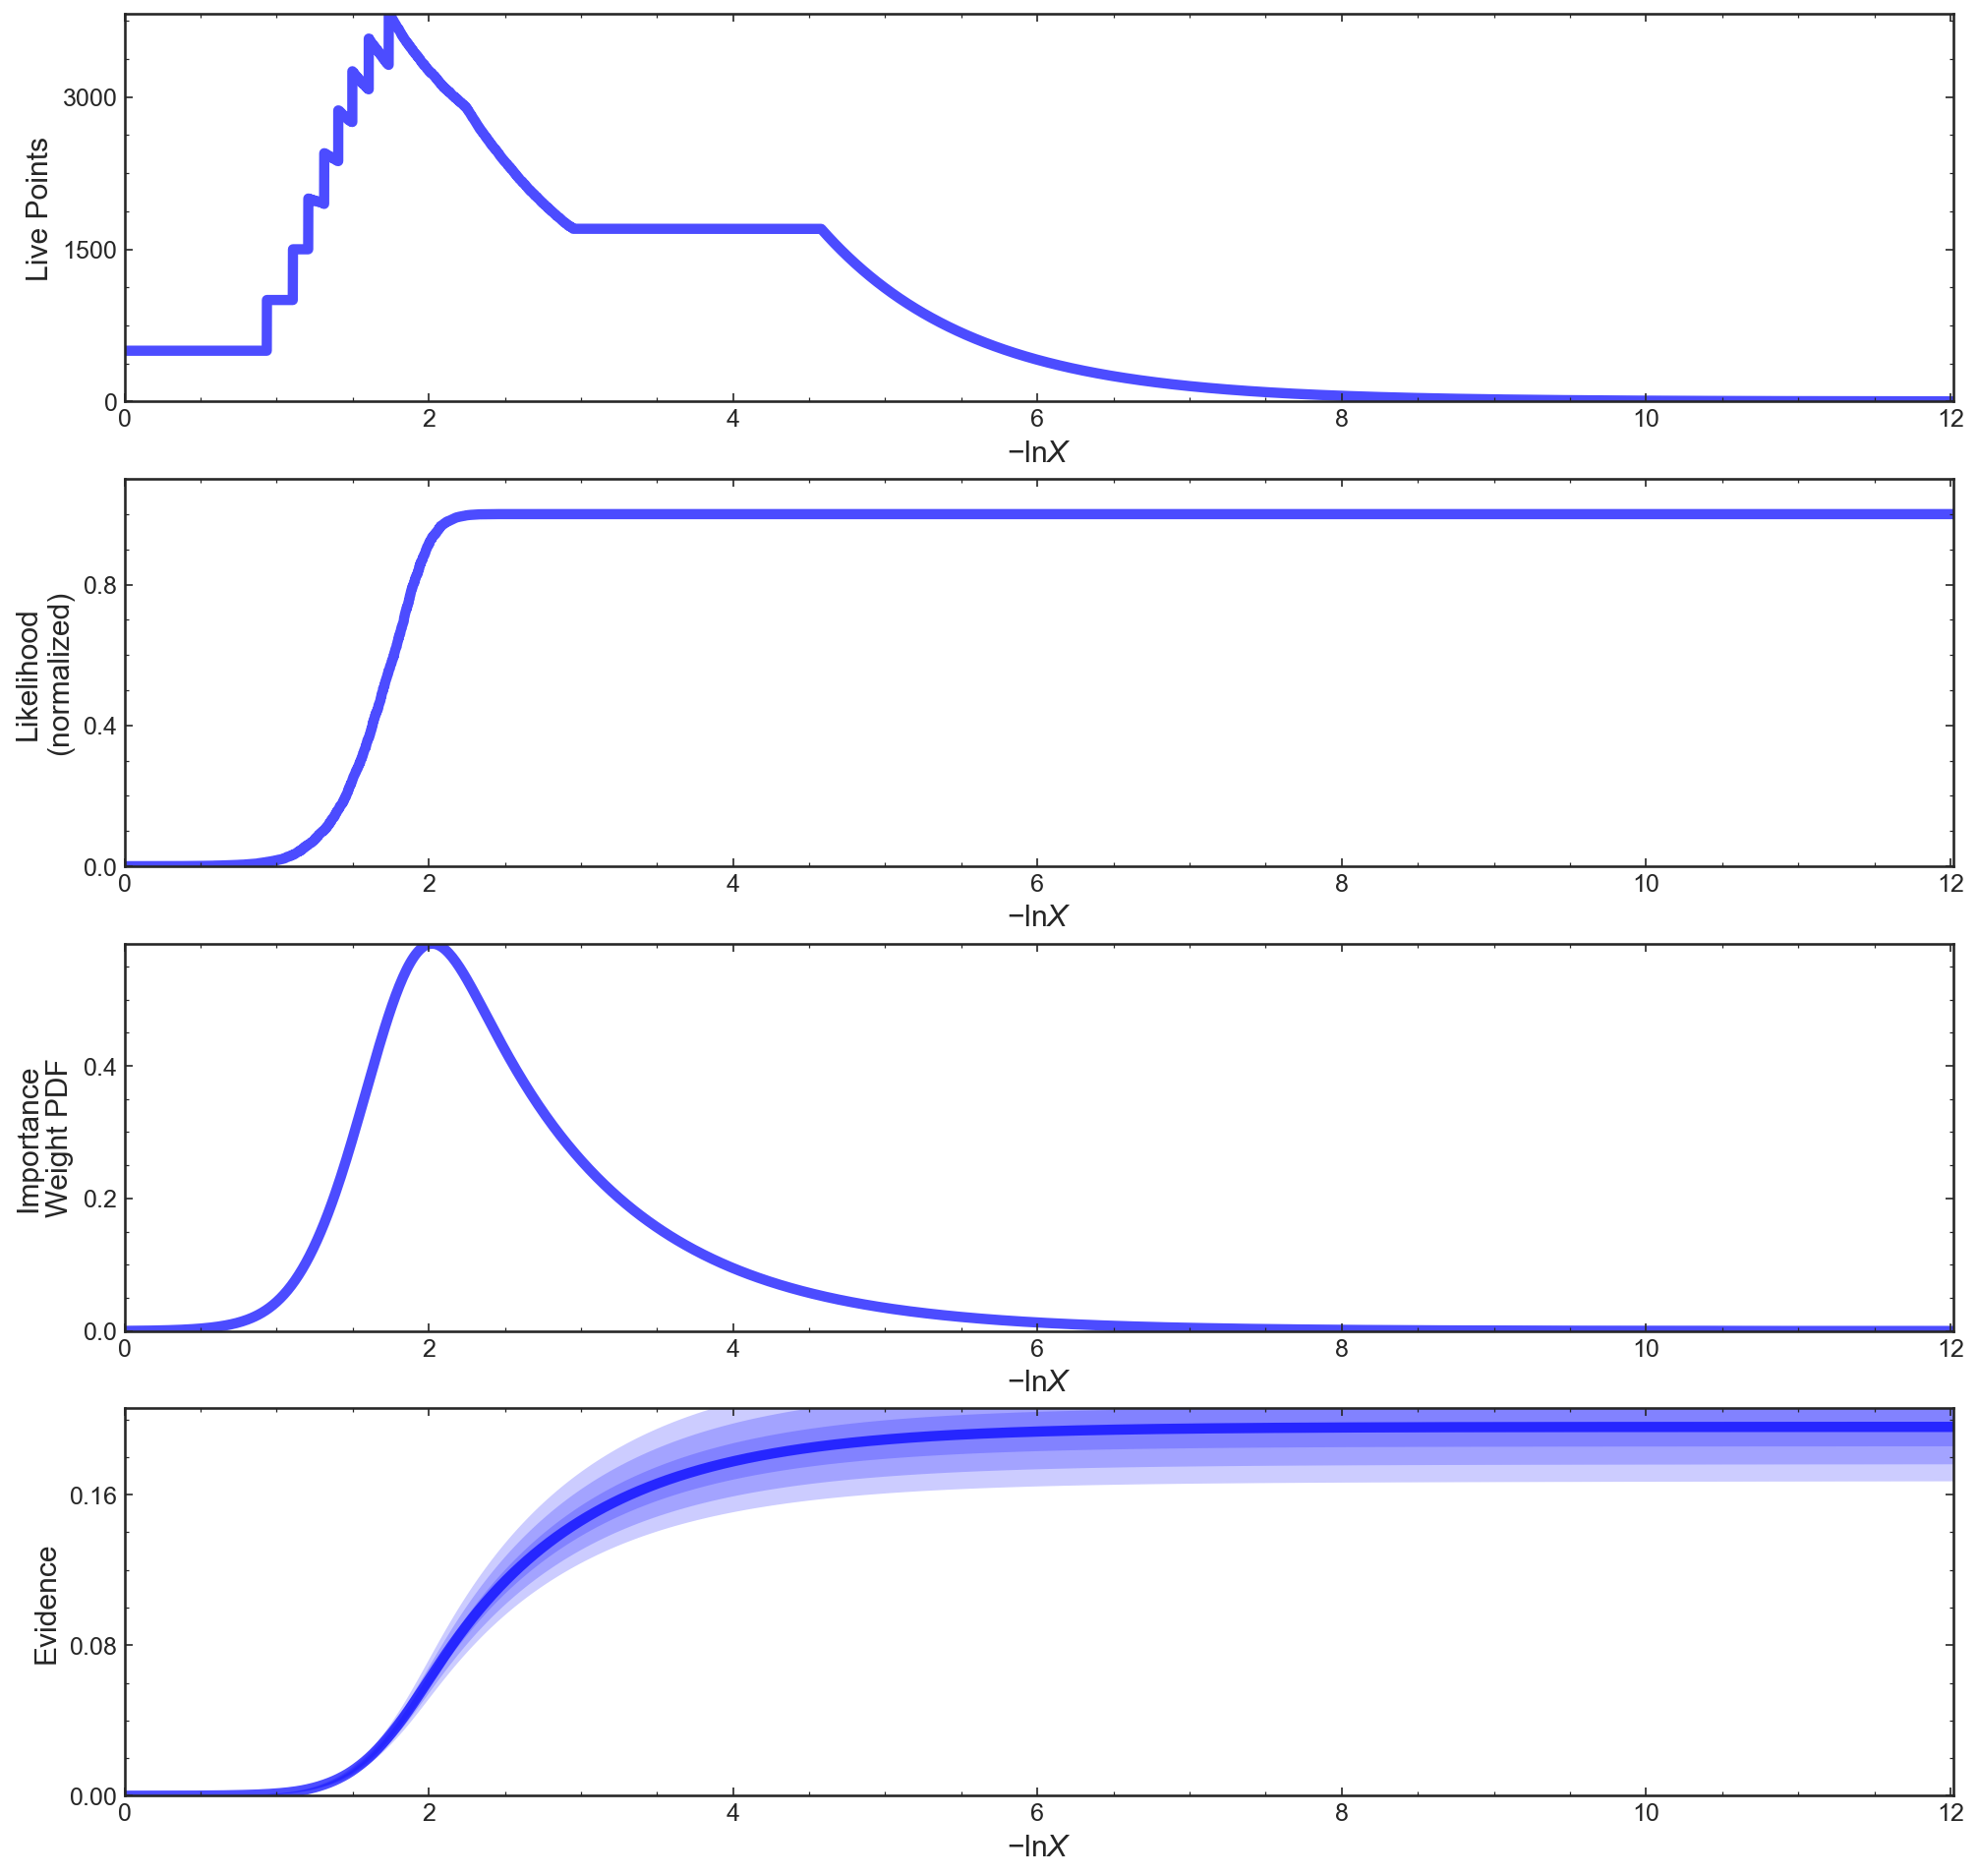

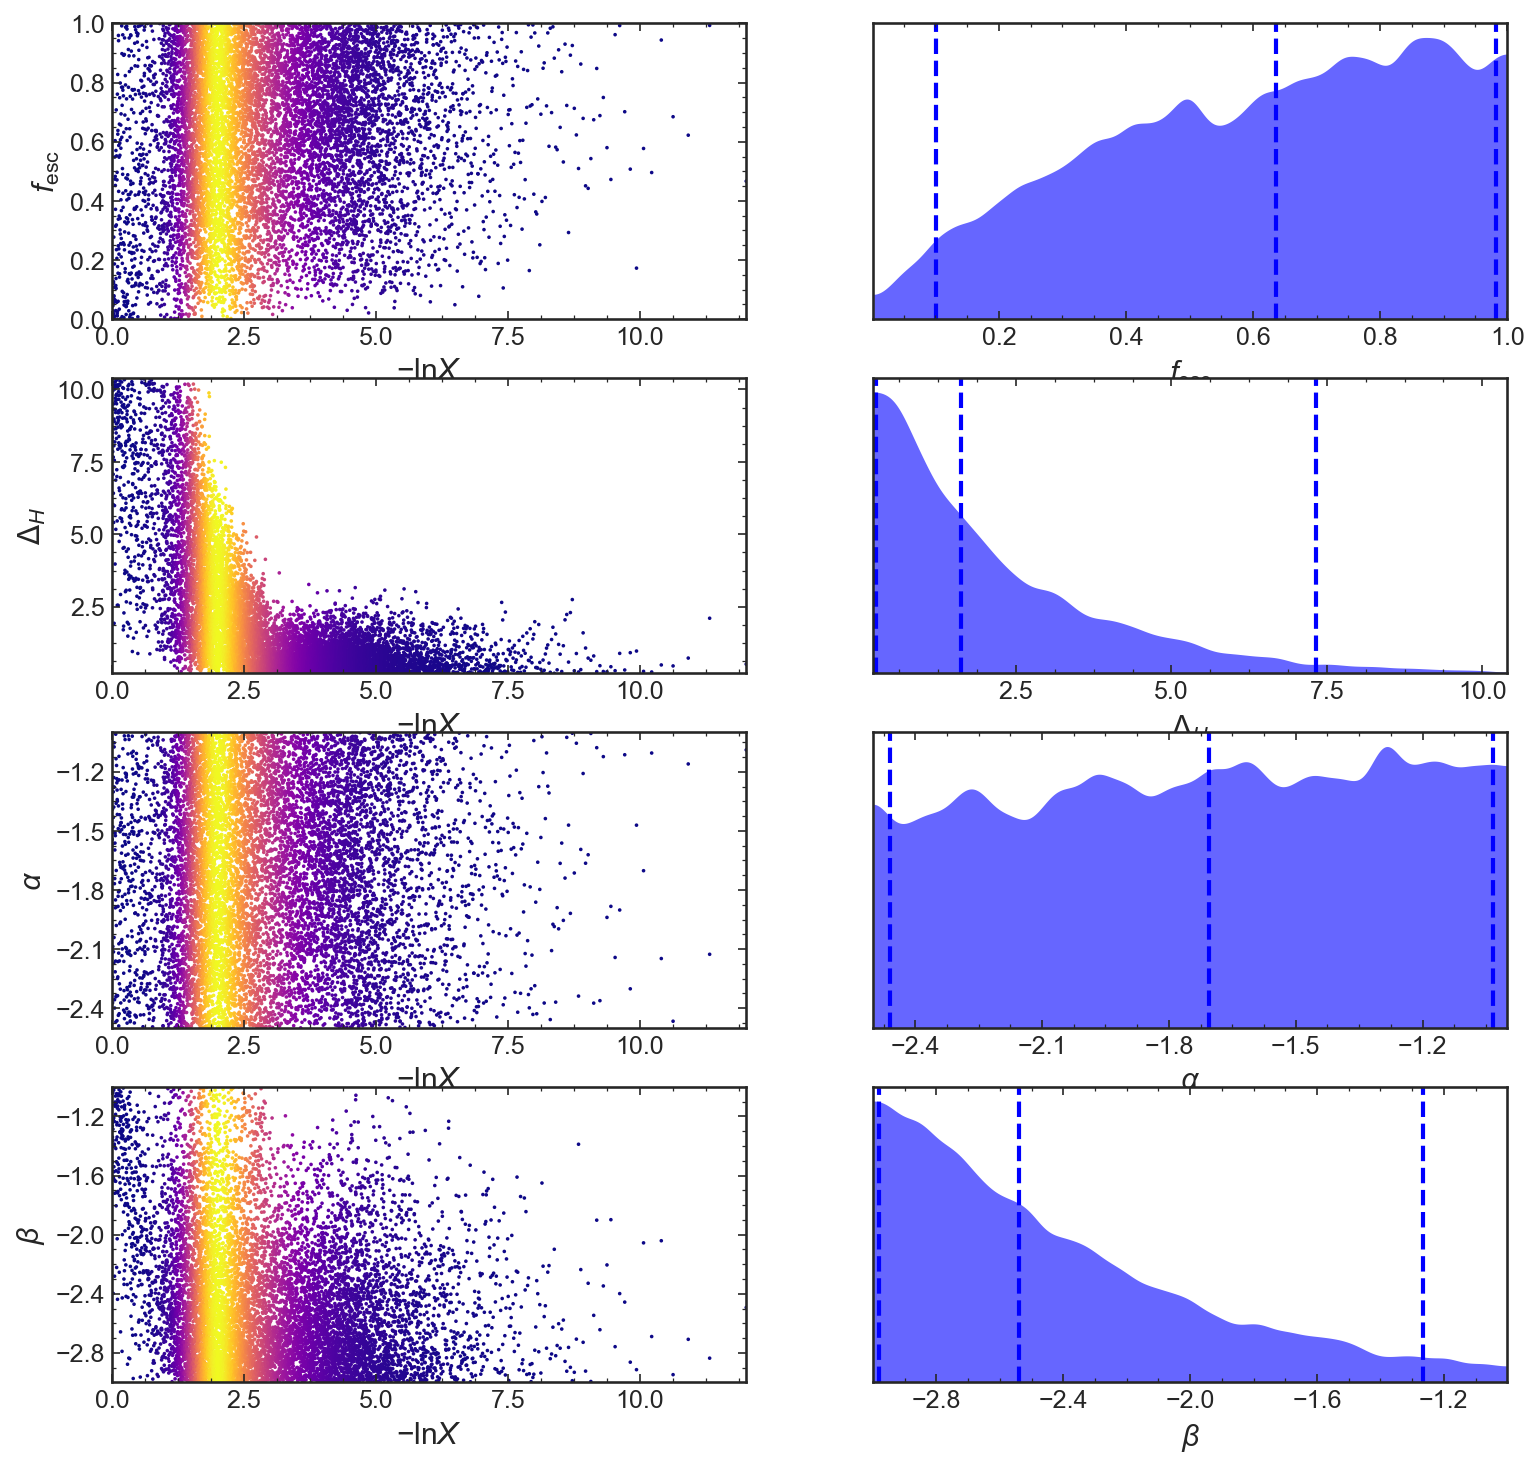

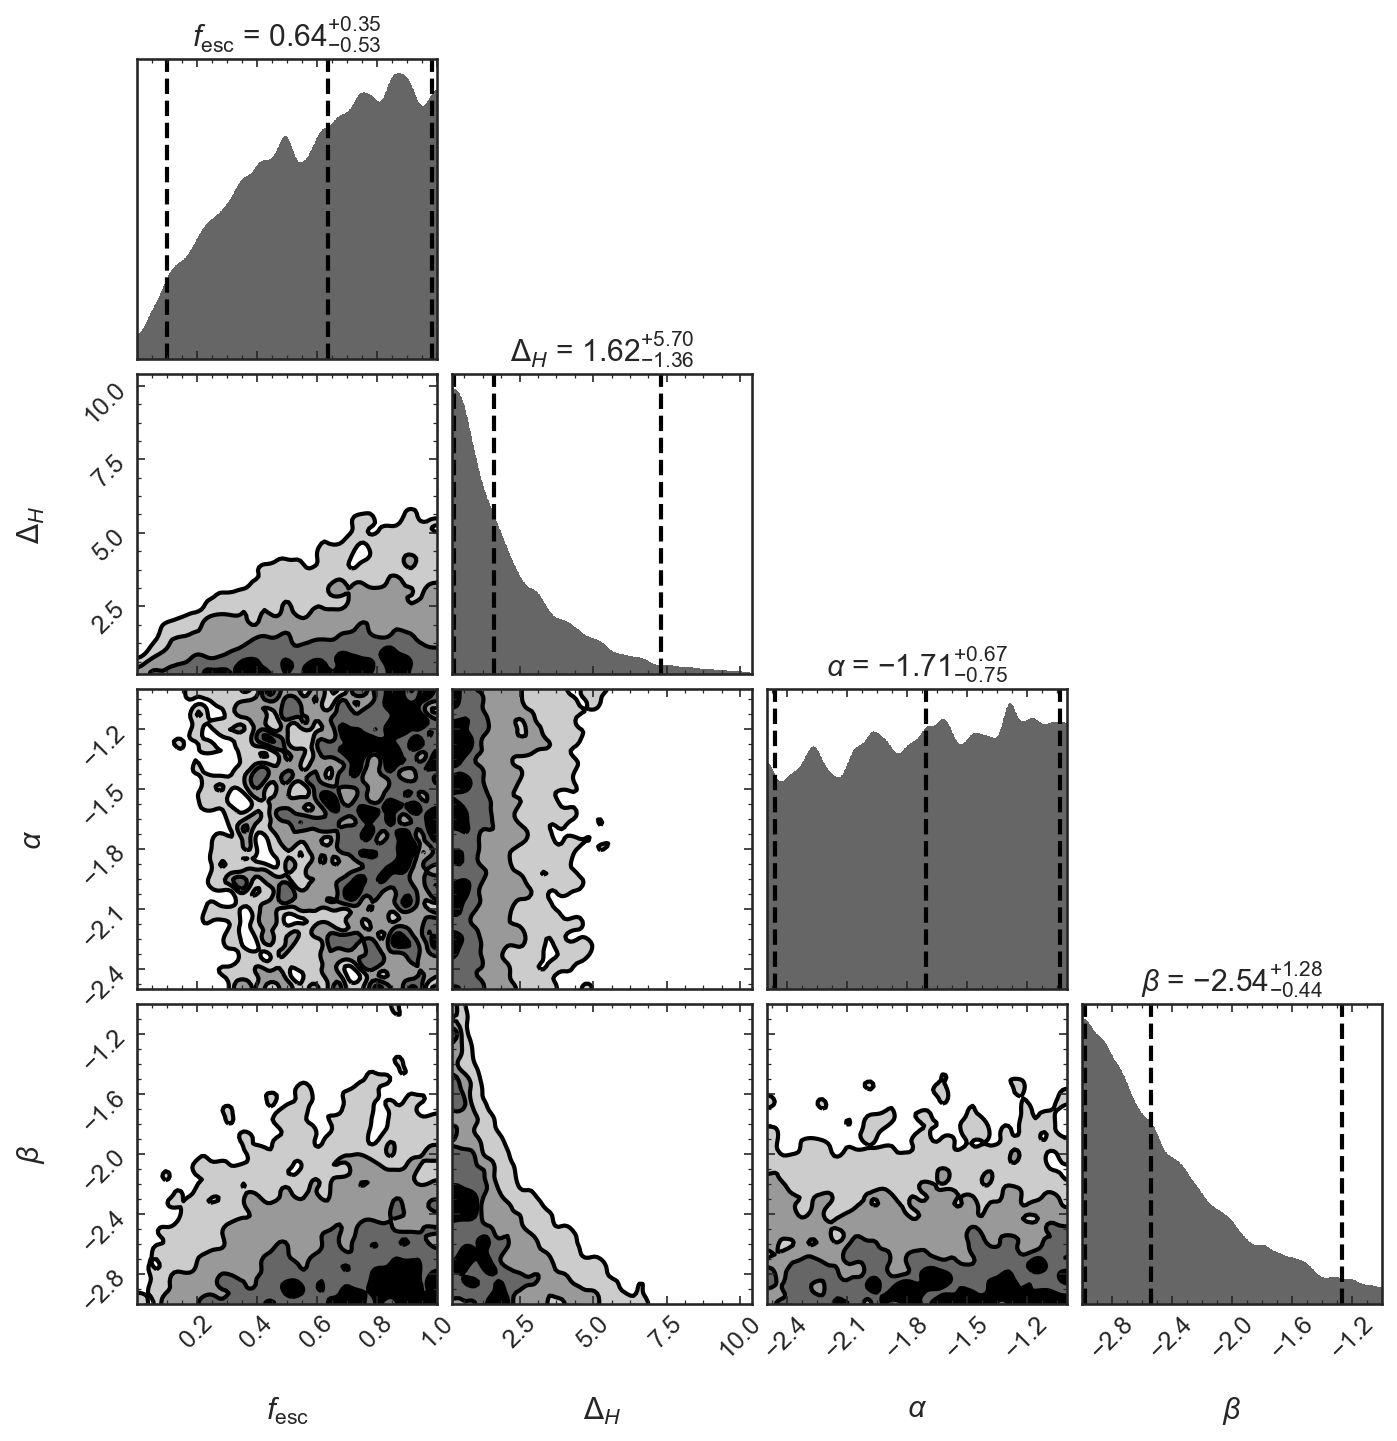

In [364]:
labels = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$', r'$\beta$']

# Plot
dyn_plots(res_fixbg, labels=labels)

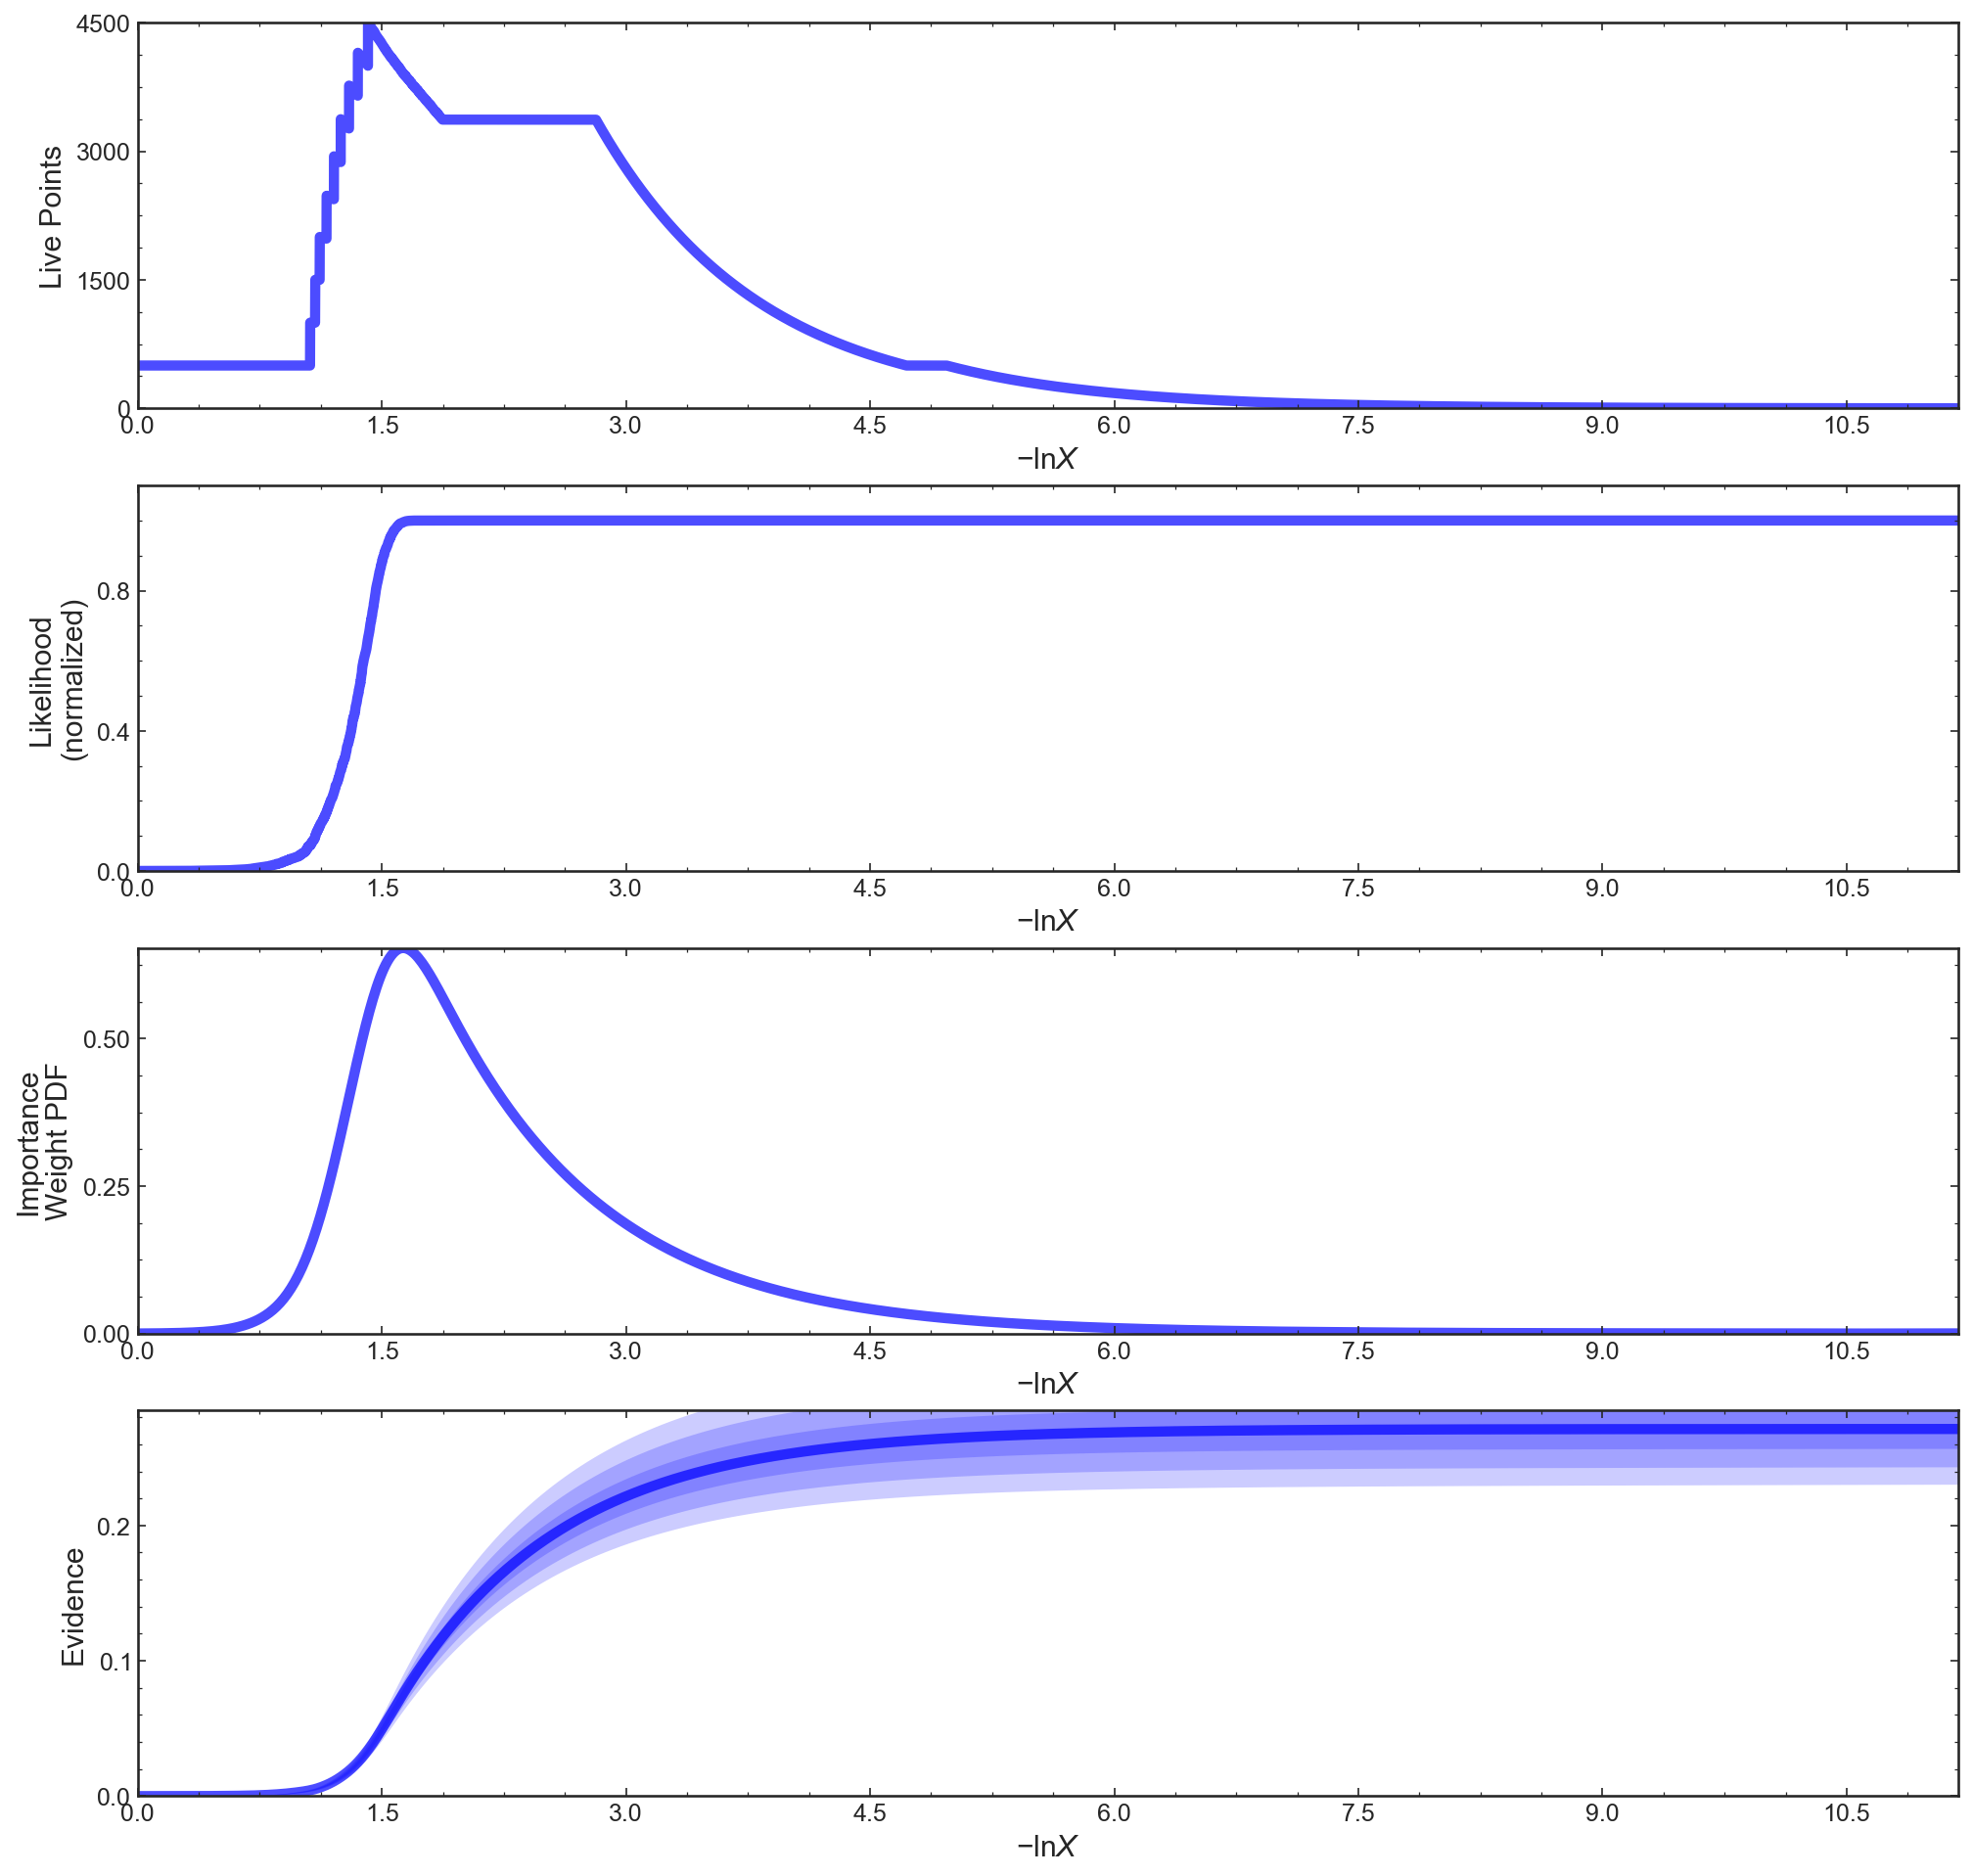

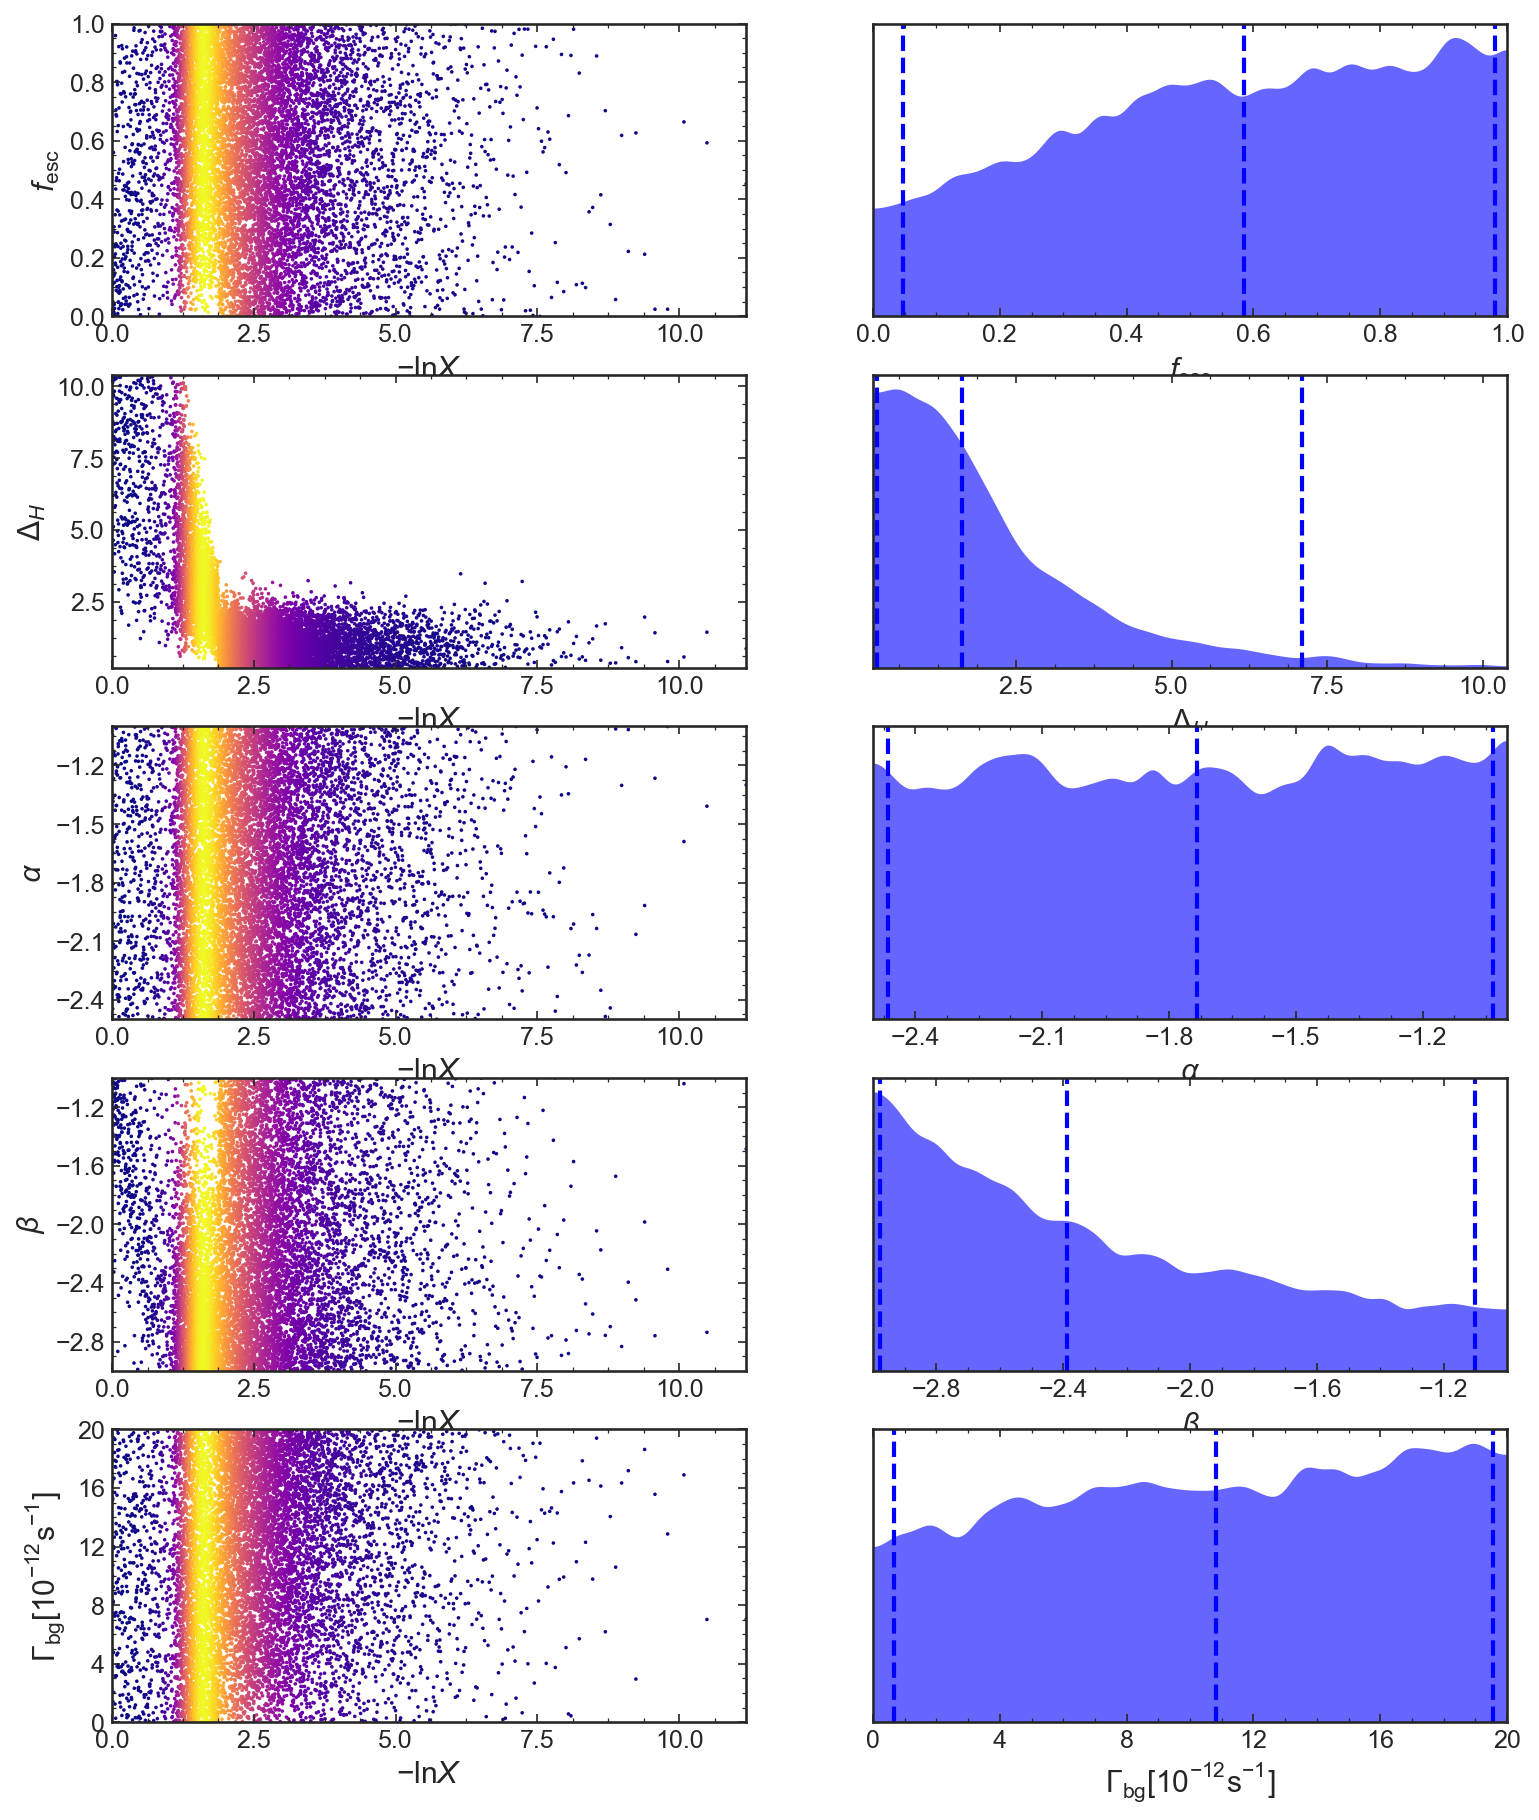

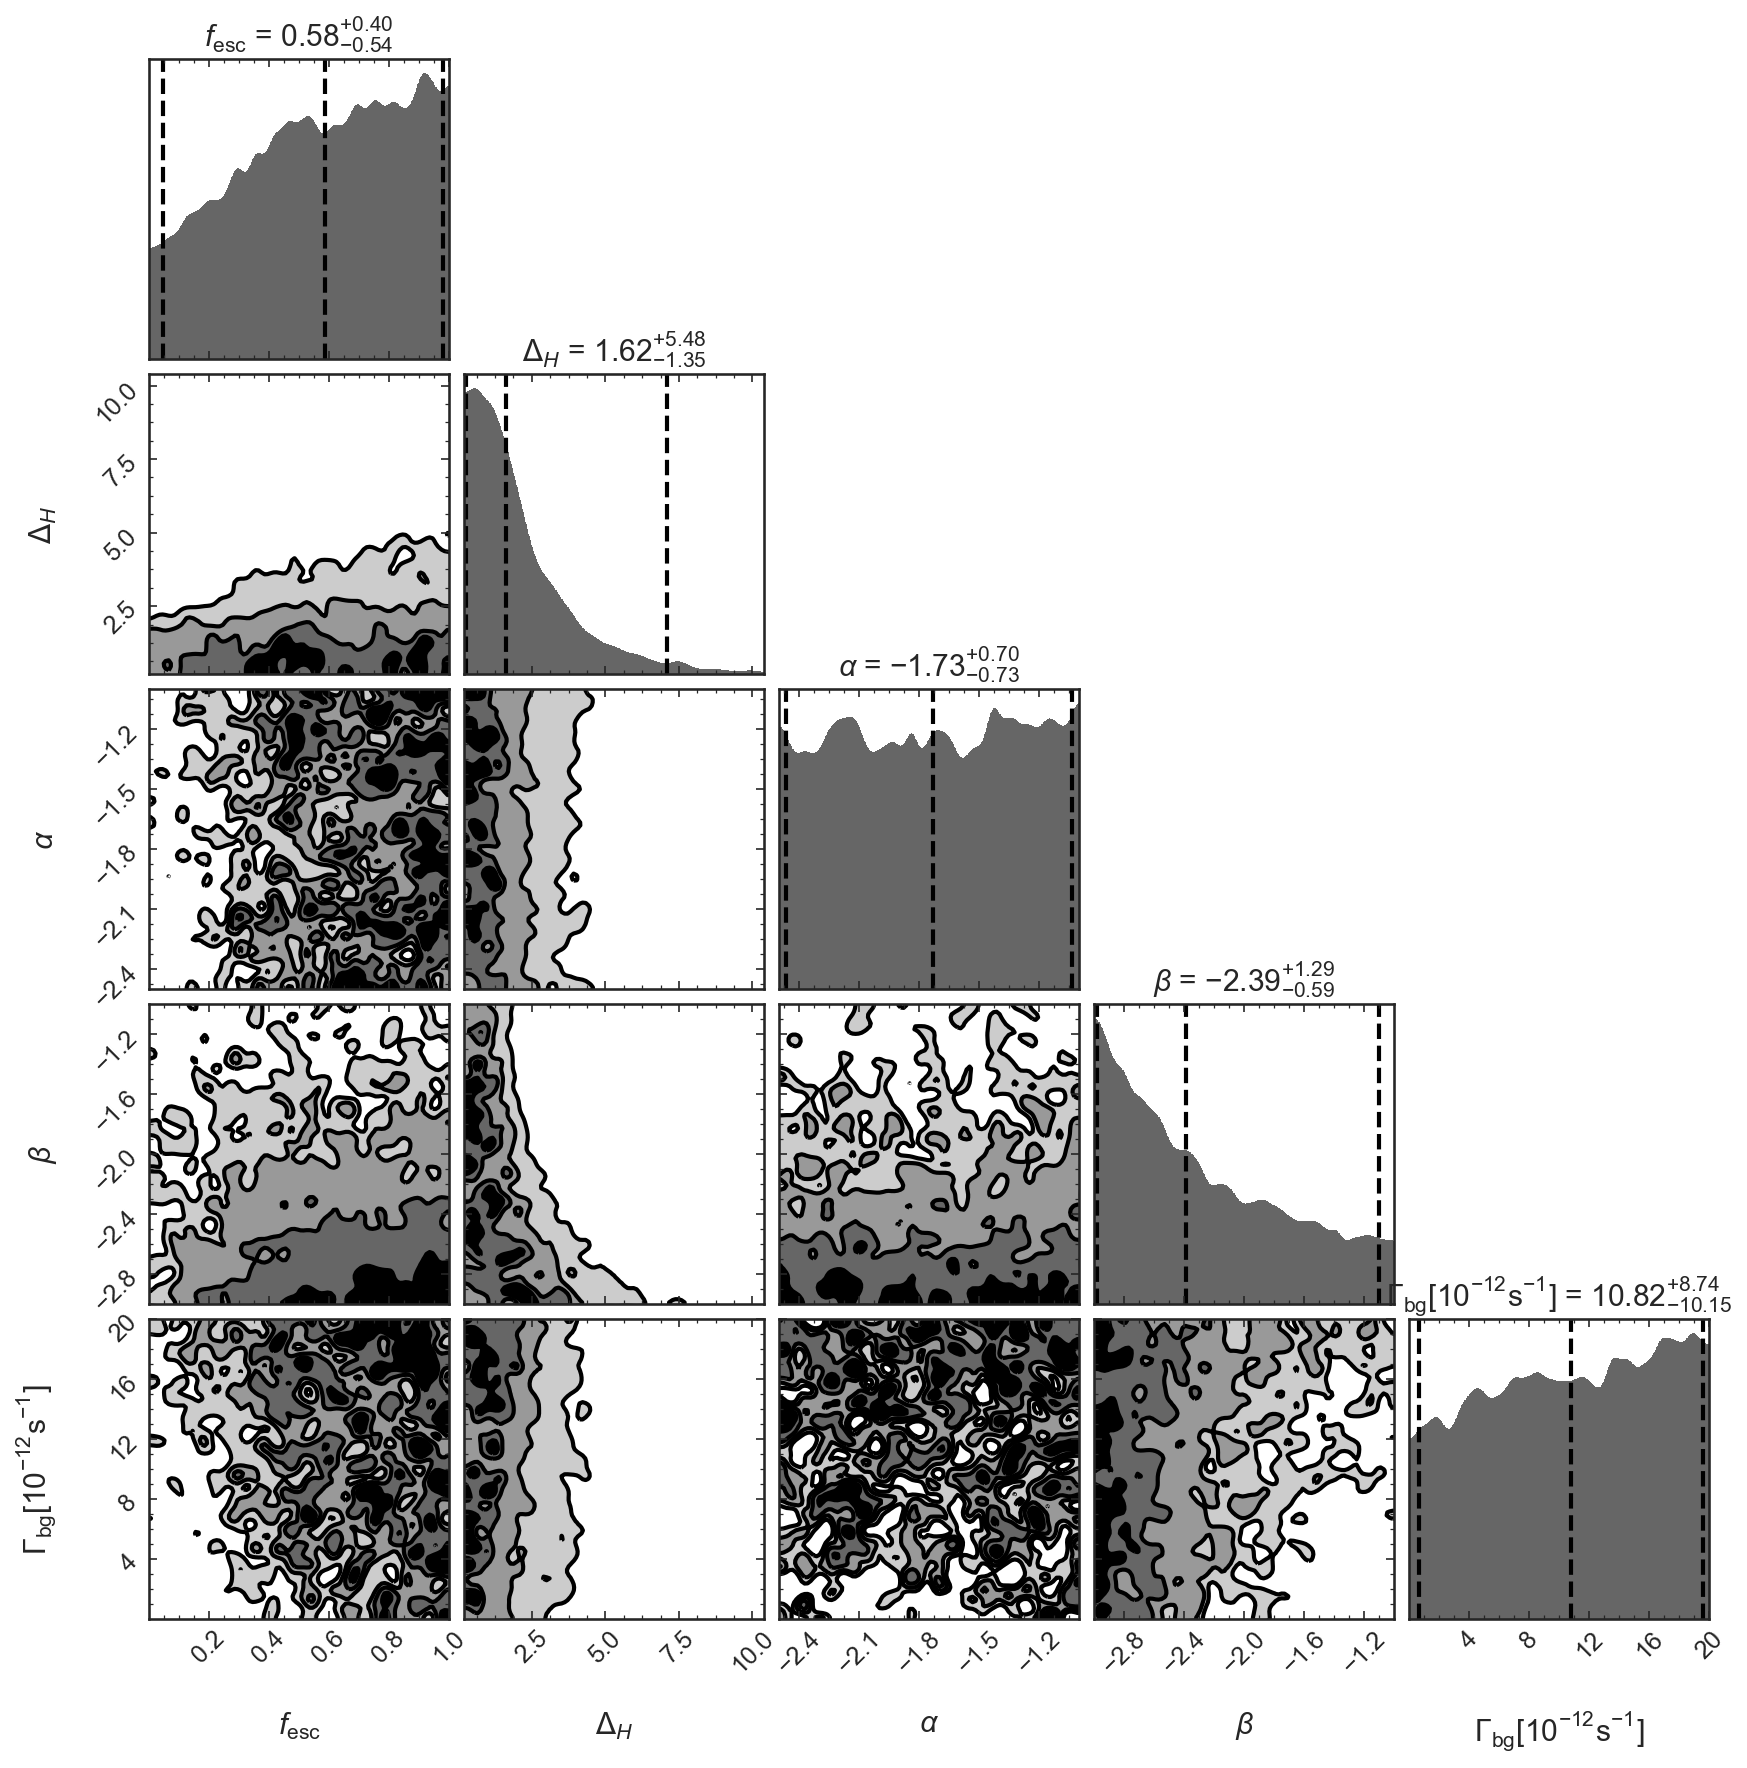

In [359]:
labels_bg = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$', r'$\beta$', r'$\Gamma_\mathrm{bg} [10^{-12} \mathrm{s}^{-1}]$']

dyn_plots(res_withbg, labels=labels_bg)

## Evidence

In [419]:
logZ_withbg = res_withbg.logz[-100:]
logZ_nobg   = res_fixbg.logz[-100:]

logBF = logZ_withbg - logZ_nobg

print(logZ_withbg[-1], logZ_nobg[-1], np.median(logBF))

print(np.exp(np.median(logBF)))

-2.216415770276438 -3.0063041857098893 0.7902069552478457
2.2038524778989474


## Load old runs

In [178]:
chain_file_nobg = "../chains/res_nobg.pickle"
flat_samples_nobg_dynesty, logZ_nobg = load_samples(chain_file_nobg)

chain_file_bg = "../chains/res_withbg_100.pickle"
flat_samples_bg_dynesty, logZ_withbg = load_samples(chain_file_bg)

print(flat_samples_bg_dynesty.shape, flat_samples_nobg_dynesty.shape)

(10000, 4) (10000, 3)


In [376]:
def get_med_errs(array, quantiles=[16., 50., 84.]):
    return [np.percentile(array, q) for q in quantiles]

def plot_compare_corner(samples1, samples2, 
                        logZ1, logZ2,
                        labels=labels,
                        col1='#8D8085', col2='#07205C', 
                        plotname='COLA1_Ralpha_corner_both_bg100.pdf'):
    
    fig, ax = plt.subplots(samples1.shape[1], samples1.shape[1], 
                           figsize=(1.8*samples1.shape[1], 1.8*samples1.shape[1]), dpi=150)

    # With background
    corner.corner(samples1, fig=fig,
                  range=[(0.,1), (0.2,10), (-2.5,-1), (-3, -1), (0,10)],
                    labels=labels_bg, smooth=2, 
                    color=col1, use_math_text=True,
                    plot_datapoints=False, plot_density=False, 
                    fill_contours=True, hist_kwargs={'lw':2, 'density':True},
                    levels = 1.0 - np.exp(-0.5 * np.array([1,2]) ** 2),
    #                 show_titles=True,        
                    label_kwargs={"fontsize": 16})


    # No background
    expand_samples2 = np.append(samples2, -5 + np.random.normal(0., 1, (len(samples2),1)), 1)
    for i,j in it.product(range(samples2.shape[1]), range(samples2.shape[1])):
        # 2D hist
        if i > j:
            corner.hist2d(expand_samples2[:,j], expand_samples2[:,i], 
                          ax=ax[i,j], bins=20, 
                          levels=1.0 - np.exp(-0.5 * np.array([1,2]) ** 2), 
                          smooth=2, color=col2, 
                          plot_datapoints=False, plot_density=False, plot_contours=True, 
                          no_fill_contours=False, fill_contours=True)
        # diagonal
        if i == j:        
            data = expand_samples2[:,i]
            n, bins, patches = ax[i,j].hist(data, bins=20, histtype='step', color=col_nobg, density=True, lw=2)
            ax[i,j].set_ylim(0., 1.1*np.max(n))

    # Set delta_H lims        
    [axi.set_xlim(0.2,10) for axi in ax[:,1]]
    ax[1,0].set_ylim(0.2,10)

    # Legend
    ax[0,1].annotate('No background ($\ln{Z} = %.2f$)' % logZ2, 
                     xy=(0.,0.85), xycoords='axes fraction', color=col2, fontsize=20)

    for i, label in enumerate(labels):    
        if i == 0: # fesc
            low_lim = get_med_errs(expand_samples2[:,i], quantiles=[100-68.])
            text = '%s$> %.2f$' % (label, low_lim[0])
        elif i == 1 or i==3: # D_H or beta
            up_lim = get_med_errs(expand_samples2[:,i], quantiles=[68.])
            text = '%s$< %.2f$' % (label, up_lim[0])        
        else:
            low, med, high = get_med_errs(expand_samples2[:,i])
            low_err, high_err = med-low, high-med
            text = '%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err)

        ax[i,i].annotate(r'%s' % text, xy=(0.95,0.5), xycoords='axes fraction', fontsize=12, ha='right', color=col2)

    ax[0,1].annotate('With ionizing background ($\ln{Z} = %.2f$)' % logZ1, 
                     xy=(0.,0.65), xycoords='axes fraction', color=col1, fontsize=20)
    for i, label in enumerate(labels_bg):
        if i == 0 or i==4: # fesc or gamma
            low_lim = get_med_errs(samples1[:,i], quantiles=[100-68.])
            if i==0:
                text = '%s$> %.2f$' % (label, low_lim[0])
            else:
                text = '%s$> %.1f$' % (label, low_lim[0])            
        elif i == 1 or i==3: # D_H or beta
            up_lim = get_med_errs(samples1[:,i], quantiles=[68.])
            text = '%s$< %.2f$' % (label, up_lim[0])         
        else: #alpha
            low, med, high = get_med_errs(samples1[:,i])
            low_err, high_err = med-low, high-med
            text = '%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err)

        ax[i,i].annotate(r'%s' % text, xy=(0.95,0.35), xycoords='axes fraction', fontsize=12, ha='right', color=col1)

    plt.savefig('../figs/%s' % plotname, bbox_inches='tight')
    
    return

## Plots

-1.3665651568303792 -1.6015928177814982 0.23502766095111904
1.2649437577964269


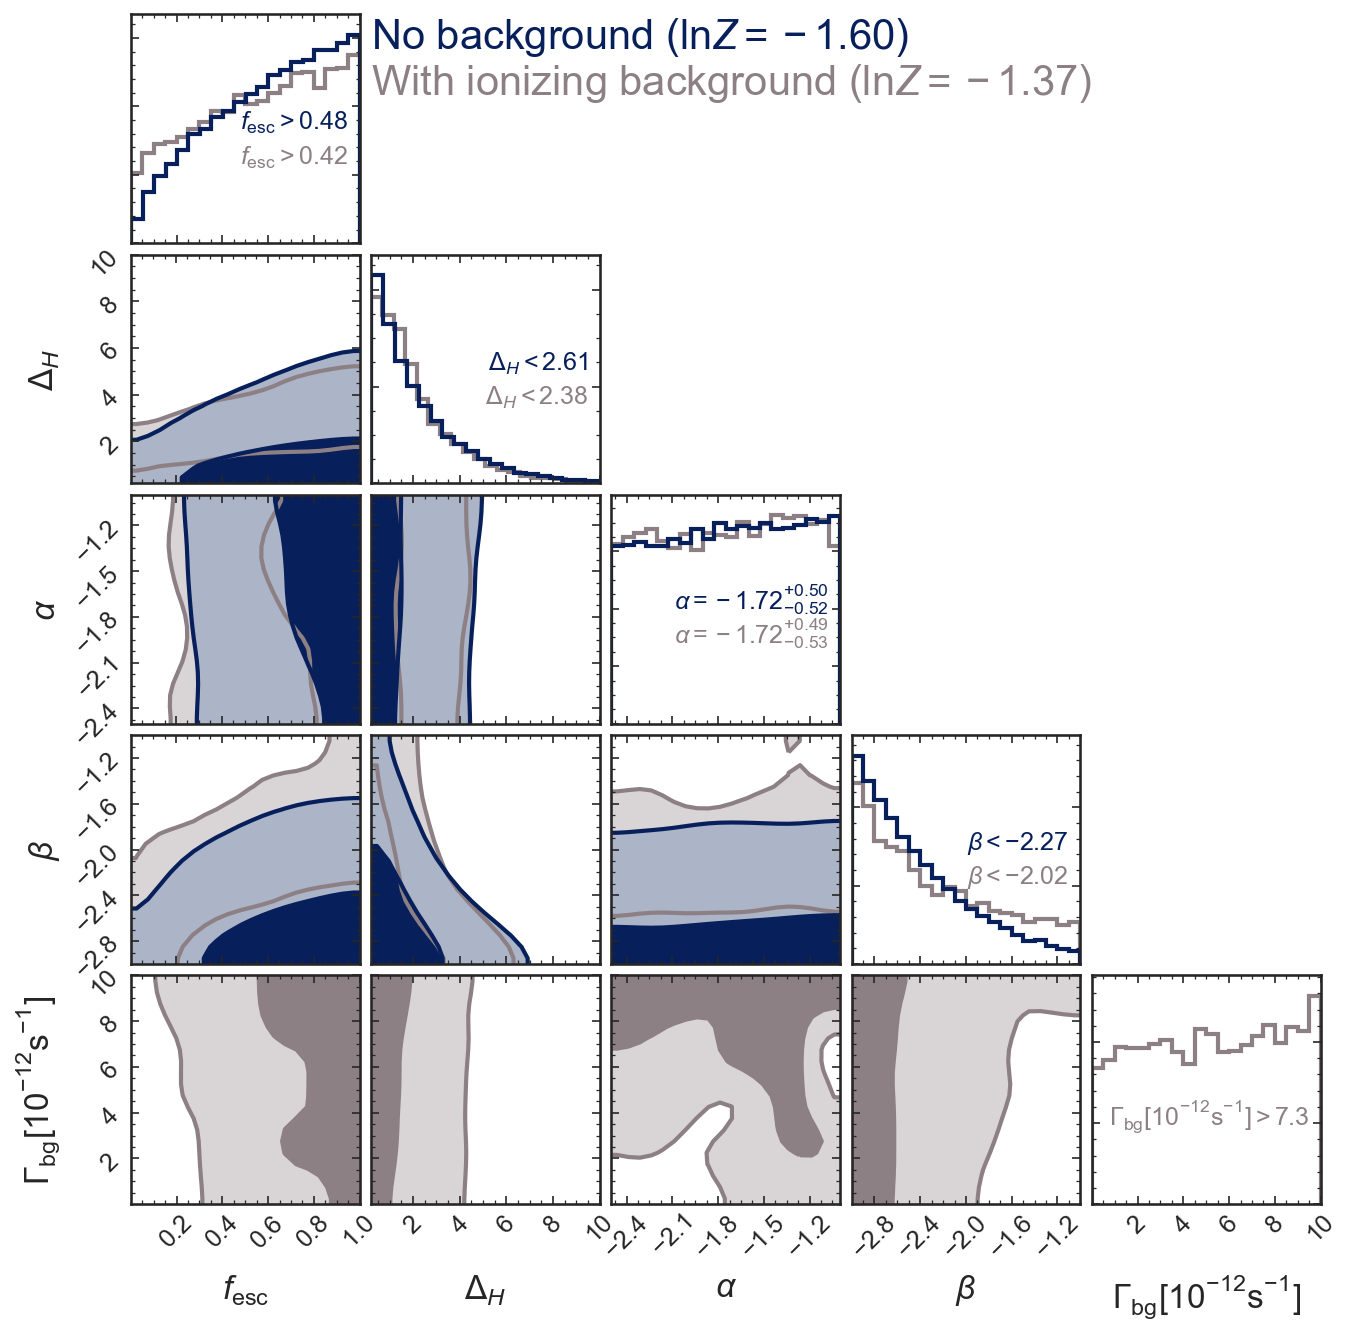

In [377]:
chain_file_nobg = "../chains/res_nobg_fixNionMuv_beta.pickle"
flat_samples_nobg_dynesty, logZ_nobg = load_samples(chain_file_nobg)

chain_file_bg = "../chains/res_withbg_fixNionMuv_beta.pickle"
flat_samples_bg_dynesty, logZ_withbg = load_samples(chain_file_bg)

plot_compare_corner(samples1=flat_samples_bg_dynesty, samples2=flat_samples_nobg_dynesty, 
                    logZ1=logZ_withbg, logZ2=logZ_nobg,
                    labels=labels,
                    col1='#8D8085', col2='#07205C', 
                    plotname='COLA1_Ralpha_corner_both_fixNionMuv_beta.pdf')

logBF = logZ_withbg - logZ_nobg

print(logZ_withbg, logZ_nobg, logBF)
print(np.exp(logBF))

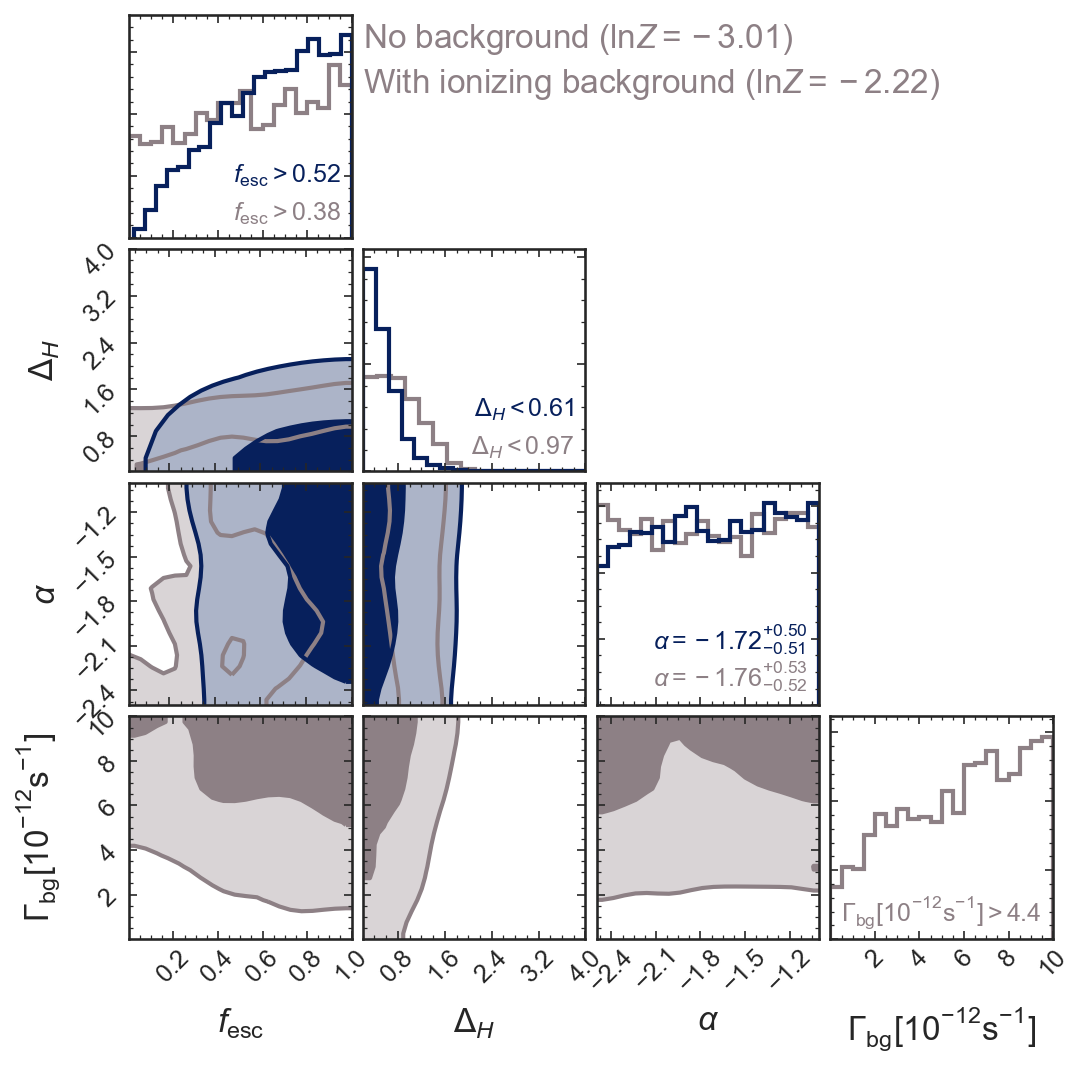

In [257]:
chain_file_nobg = "../chains/res_nobg.pickle"
flat_samples_nobg_dynesty, logZ_nobg = load_samples(chain_file_nobg)

chain_file_bg = "../chains/res_withbg.pickle"
flat_samples_bg_dynesty, logZ_withbg = load_samples(chain_file_bg)

plot_compare_corner(samples1=flat_samples_bg_dynesty, samples2=flat_samples_nobg_dynesty, 
                    logZ1=logZ_withbg, logZ2=logZ_nobg,
                    labels=labels,
                    col1='#8D8085', col2='#07205C', 
                    plotname='COLA1_Ralpha_corner_both.pdf')

# For same Nion what is xHI in from a single source or multiple?

1.3866650680111756 Mpc


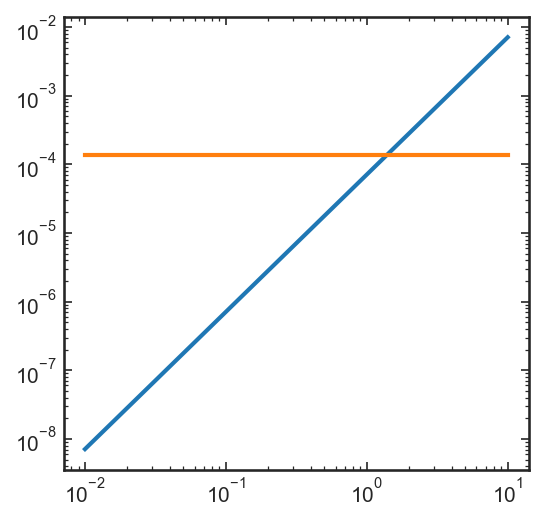

In [63]:
def gamma_s(Ndot_ion=1e55/u.s, fesc=1, alpha=-2):
    sigma_ion0 = 6.3e-18 * u.cm**2
    return -fesc * Ndot_ion * (alpha/alpha-3) * sigma_ion0

def xHI(gamma_s, C=3, z=7, T=1e4):
    return C*bubbles.n_H(z)*bubbles.alpha_rec_B(T)/gamma_s

R_tab = np.logspace(-2,1) * u.Mpc # proper
z_s0 = 7.
Ndot_ion = 1e55/u.s

R_ion = bubbles.R_bubble_CenHaiman2000(z_s0, Ndot_ion=Ndot_ion, t_source=1e8*u.yr)
print(R_ion)

gamma = gamma_s(Ndot_ion=Ndot_ion)

gamma_single_source = gamma/4./np.pi/R_tab.to(u.cm)**2.

plt.loglog(R_tab, xHI(gamma_single_source, z=z_s0))
plt.loglog(R_tab, xHI(gamma/4./np.pi/R_ion.to(u.cm)**2., z=z_s0)*np.ones_like(R_tab))

# source spread through whole bubble


# How much does xHI need to change by to drop Lya fraction by 1/2

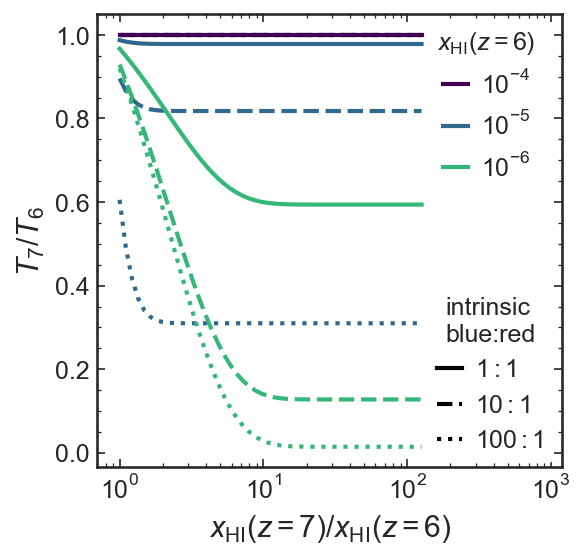

In [98]:
def tau_GP(z, xHI, C=1):
    tau = 1.34e-7*u.cm**3/u.s * C * xHI * bubbles.n_H(z)/Planck15.H(z)
    return tau.to(u.cm/u.cm)

def T_ratio(z1, z2, xHI1, dxHI, R=1, C1=1, C2=1):
    T_z1 = np.exp(-tau_GP(z1, xHI1, C=C1)) + R
    T_z2 = np.exp(-tau_GP(z2, dxHI*xHI1, C=C2)) + R
    return T_z2/T_z1
    
# xtab = np.logspace(-9, -4)
# plt.semilogx(xtab, np.exp(-(tau_GP(7, xHI=xtab) - tau_GP(6, xHI=xtab))))

xtab = np.logspace(0, 2.1)
x1   = 1e-4

R_test = [1., 0.1, 0.01]
ls = ['solid', 'dashed', 'dotted']
xHI_test = np.logspace(-4,-7,4)

s_m = bubbles.scalar_mappable(np.log10(xHI_test), cmap='viridis_r')
    
for x1 in xHI_test[:-1]:
    
    for rr, R in enumerate(R_test):
        if rr == 0:
            label = '$10^{%.0f}$' % np.log10(x1)
        else:
            label = None
        
        T_76 = T_ratio(z1=6., z2=7., xHI1=x1, dxHI=xtab, R=R, C1=1, C2=1)
        ln = plt.semilogx(xtab, T_76, c=s_m.to_rgba(np.log10(x1)), ls=ls[rr], label=label)
    
handles = []
for rr, R in enumerate(R_test):
    ln = mlines.Line2D([], [], color='k', ls=ls[rr], label=r'$%.0f:1$' % (1/R))
    handles.append(ln)
    
leg = plt.legend(loc=(0.71, 0.01), title='intrinsic\nblue:red', handles=handles, 
                 handlelength=1., handletextpad=0.5,frameon=True, framealpha=1)
plt.gca().add_artist(leg)

plt.legend(loc=(0.71, 0.61), title='$x_\mathrm{HI}(z=6)$', 
           handlelength=1., handletextpad=0.5, frameon=True, framealpha=1)
plt.xlabel('$x_\mathrm{HI}(z=7)/x_\mathrm{HI}(z=6)$')
plt.ylabel('$T_7/T_6$')

plt.xlim(7e-1, 1.2e3)

plt.savefig('../figs/transmission_blue_red.pdf', bbox_inches='tight')

In [39]:
def z_at_R(zs, r_p):
    return zs - r_p * Planck15.H(zs) * (1+zs)/const.c

z_at_R(7., r_p=1.*u.Mpc)

<Quantity 6.97719355>

<Quantity 6.97719355>

# Simple R_alpha equation

$$R_\alpha = f_{esc} N_{ion} \frac{\alpha}{\alpha -3} \frac{\sqrt{H(z) \tau_{lim}}}{\Delta_h n_h\sqrt{\alpha_B(T)}} \frac{\sigma_{ion,0}}{4\pi\sqrt{A}}$$

In [379]:
A = 1.34e-7 * u.cm**3. / u.s
sigma_ion0 = 6.3e-18 * u.cm**2

factor = sigma_ion0 / 4/np.pi/np.sqrt(A)
factor

<Quantity 1.36955124e-15 cm(1/2) s(1/2)>

In [380]:
2.3/(1+6.6)

0.3026315789473684